Final Project MGSC-404

Amine Kobeissi,
Ryan Stewart


In this project we are tasked with helping a bike company optimize their bike movements. We will begin by cleaning and processing the data. Next we will visualize the data, extract new information from it, like the truck movements, and then finally formulate and solve an LP.

In [46]:
#Main packages
import pandas as pd
import numpy as np
import math
import statistics
from datascience import *

from datetime import time, timedelta, datetime,date #Converting to datetime
from geopy import distance

#Plotting packages
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
import folium
from folium import plugins

%matplotlib inline


##### NOTE: The interpretation and explanation of code will be found underneath the code cell. For example, for code in cell 1, the interpretation is in cell 2

In [47]:
#Import data sets using pandas and datascience
df_Q3 = pd.read_csv("Divvy_Trips_2017_Q3.csv") #Bikeshare data for Q3
df_Q4 = pd.read_csv("Divvy_Trips_2017_Q4.csv") #Bikeshare data for Q4
df_geo = pd.read_csv("Divvy_Stations_2017_Q3Q4.csv") #Geo and station data for Q3 and Q4

### 1 - Data Exploration and Processing

In [48]:
#Get a sense of the data and see what the df contains
df_Q3.head(5)
df_Q4.head(5)
#df_geo.head(5)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,17536701,12/31/2017 23:58,1/1/2018 0:03,3304,284,159,Claremont Ave & Hirsch St,69,Damen Ave & Pierce Ave,Subscriber,Male,1988.0
1,17536700,12/31/2017 23:54,1/1/2018 0:18,5975,1402,145,Mies van der Rohe Way & Chestnut St,145,Mies van der Rohe Way & Chestnut St,Customer,NaN,NaN
2,17536699,12/31/2017 23:54,1/1/2018 0:18,4906,1441,145,Mies van der Rohe Way & Chestnut St,145,Mies van der Rohe Way & Chestnut St,Customer,NaN,NaN
3,17536698,12/31/2017 23:48,12/31/2017 23:53,5667,315,340,Clark St & Wrightwood Ave,143,Sedgwick St & Webster Ave,Subscriber,Male,1963.0
4,17536697,12/31/2017 23:42,12/31/2017 23:47,5353,272,240,Sheridan Rd & Irving Park Rd,245,Clarendon Ave & Junior Ter,Subscriber,Male,1977.0


In [49]:
print("Quarter 3 dataframe shape: ", df_Q3.shape)
print("Quarter 4 dataframe shape: ", df_Q4.shape)
print("Geo dataframe shape: ", df_geo.shape)

Quarter 3 dataframe shape:  (1608270, 12)
Quarter 4 dataframe shape:  (669239, 12)
Geo dataframe shape:  (585, 8)


**Initial Assumptions from number of rows and columns:** <br>
From the above code, we can see that Q3 has the most observations with approximately 1.6 million recorded trips. Q4 had approximately 700,000 recorded trips. Further, since the Geo dataframe has 585 rows, we can make the initial assumption that 

In [50]:
#See the column names
column_namesQ3 = list(df_Q3.columns)
column_namesQ3

['trip_id',
 'start_time',
 'end_time',
 'bikeid',
 'tripduration',
 'from_station_id',
 'from_station_name',
 'to_station_id',
 'to_station_name',
 'usertype',
 'gender',
 'birthyear']

In [51]:
#See the column names
column_namesGeo = list(df_geo.columns)
column_namesGeo

['id',
 'name',
 'city',
 'latitude',
 'longitude',
 'dpcapacity',
 'online_date',
 'Unnamed: 7']

In [52]:
df_Q3.info()
df_Q4.info()
df_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608270 entries, 0 to 1608269
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   trip_id            1608270 non-null  int64  
 1   start_time         1608270 non-null  object 
 2   end_time           1608270 non-null  object 
 3   bikeid             1608270 non-null  int64  
 4   tripduration       1608270 non-null  int64  
 5   from_station_id    1608270 non-null  int64  
 6   from_station_name  1608270 non-null  object 
 7   to_station_id      1608270 non-null  int64  
 8   to_station_name    1608270 non-null  object 
 9   usertype           1608270 non-null  object 
 10  gender             1166890 non-null  object 
 11  birthyear          1167022 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 147.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669239 entries, 0 to 669238
Data columns (total 12 columns):
 #   Column 

The .info() fuinction helps us see the data types of each column. Its good to see that the numeric values are already in integer or float formats. One thing to note is that it would help us to change the time columns to a datetime format, so that it will facilitate splitting the data by hour, day, month...

In [53]:
df_Q3['start_time'] = pd.to_datetime(df_Q3['start_time'])
df_Q3['end_time'] = pd.to_datetime(df_Q3['end_time'])


In [54]:
#Check data for any NA values
df_Q3.isna().sum()

trip_id                   0
start_time                0
end_time                  0
bikeid                    0
tripduration              0
from_station_id           0
from_station_name         0
to_station_id             0
to_station_name           0
usertype                  0
gender               441380
birthyear            441248
dtype: int64

In [55]:
df_Q4.isna().sum()

trip_id                  0
start_time               0
end_time                 0
bikeid                   0
tripduration             0
from_station_id          0
from_station_name        0
to_station_id            0
to_station_name          0
usertype                 0
gender               78580
birthyear            78827
dtype: int64

In [56]:
df_geo.isna().sum()

id               0
name             0
city             0
latitude         0
longitude        0
dpcapacity       0
online_date      0
Unnamed: 7     585
dtype: int64

<AxesSubplot:>

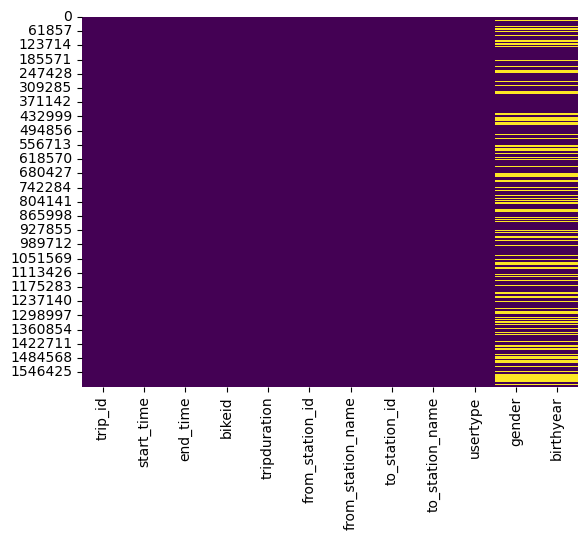

In [57]:
#Visualize NA values
sb.heatmap(df_Q3.isnull(),cbar=False,cmap='viridis')

In [58]:
#There is a column in the stations (df_geo) data that is unnamed and only contains NA's, therefore we will drop it
df_geo = df_geo.drop(columns=['Unnamed: 7'])

### Q3 - Getting Datetime features from the data

In [59]:
monthMap = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
            7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}


In [60]:
df_Q3['date']   = df_Q3.start_time.dt.date

df_Q3['year'] = df_Q3['start_time'].dt.year

df_Q3['month'] = df_Q3['start_time'].dt.month

df_Q3['dayofmonth'] = df_Q3['start_time'].dt.day

df_Q3['hour'] = df_Q3['start_time'].dt.hour

df_Q3['minute'] = df_Q3['start_time'].dt.minute

df_Q3['months'] = df_Q3['month'].map(monthMap)

df_Q3['weekend'] = np.where(df_Q3.start_time.dt.weekday > 4 , 1, 0)

# Adding 'dayofyear' column
df_Q3['dayofyear'] = df_Q3['start_time'].dt.dayofyear

# Adding 'dayofweek' column
df_Q3['dayofweek'] = df_Q3['start_time'].dt.day_name().str[:3]

### Q3 General trips statistics - Duration

In [62]:
#Look at trip durations
print("The max trip duration in Q3 is:", max(df_Q3['tripduration']))
print("The max trip duration in Q3 is:",min(df_Q3['tripduration']))
print("The range of trip duration in Q3 is:",max(df_Q3['tripduration']) - min(df_Q3['tripduration']))
print(" ")
print("The average trip duration in Q3 is:",df_Q3['tripduration'].mean())
print("The median trip duration in Q3 is:", statistics.median(list(df_Q3['tripduration'])))
print("The mode of the trip durations in Q3 is:", statistics.mode(list(df_Q3['tripduration'])))
print("The standard devation of trip durations in Q3 is:", statistics.stdev(list(df_Q3['tripduration'])))

print(" ")
print("The trip duration by user type in Q3 is",df_Q3['tripduration'].groupby(df_Q3['usertype']).mean())

The max trip duration in Q3 is: 86014
The max trip duration in Q3 is: 60
The range of trip duration in Q3 is: 85954
 
The average trip duration in Q3 is: 1044.2485067805778
The median trip duration in Q3 is: 764.0
The mode of the trip durations in Q3 is: 372
The standard devation of trip durations in Q3 is: 1614.8380327409834
 
The trip duration by user type in Q3 is usertype
Customer      1851.261288
Dependent     1148.666667
Subscriber     738.760527
Name: tripduration, dtype: float64


##### From these general trip stats it looks like the data is skewed to the right. This is evident from the central limit theorem, since the mean is greater than both the median and the mode, the data is positively skewed.

/Users/Temporary/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tripduration', ylabel='Density'>

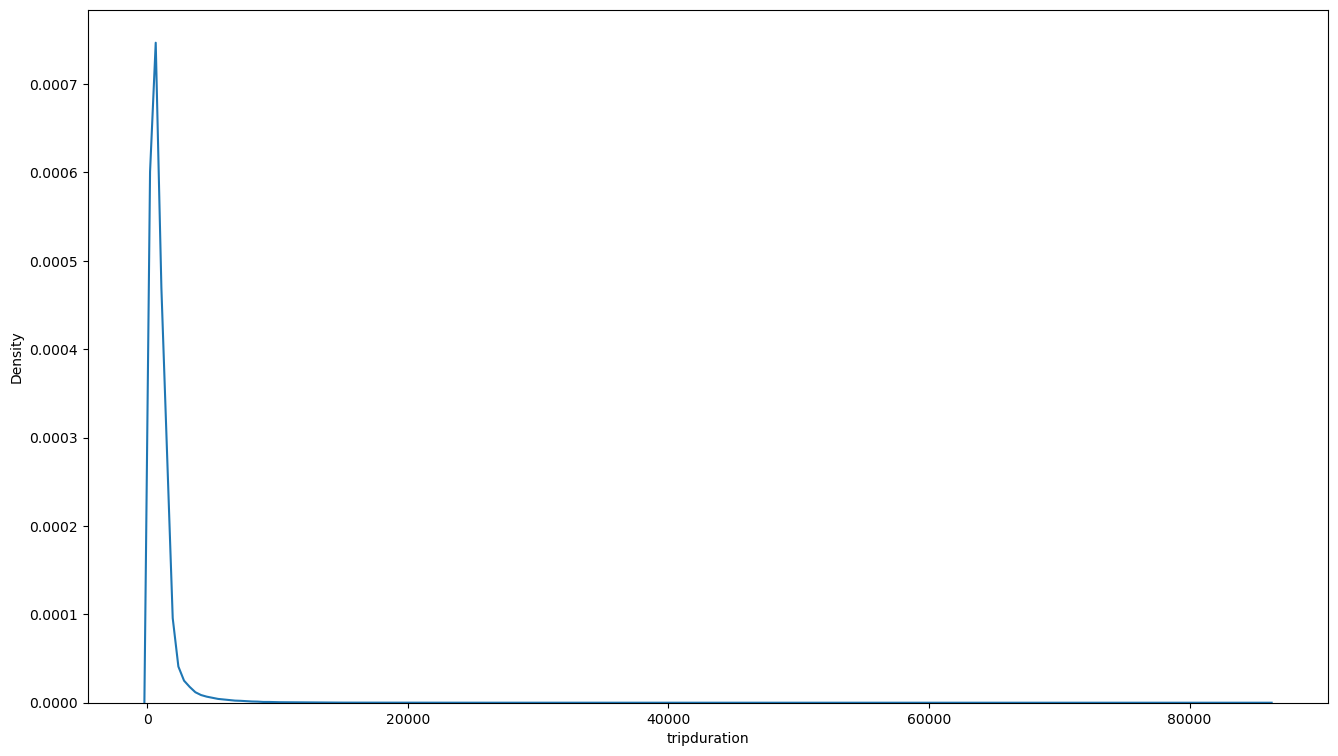

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sb.distplot(df_Q3['tripduration'], hist=False, ax=ax)

AxesSubplot(0.125,0.11;0.775x0.77)


/Users/Temporary/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


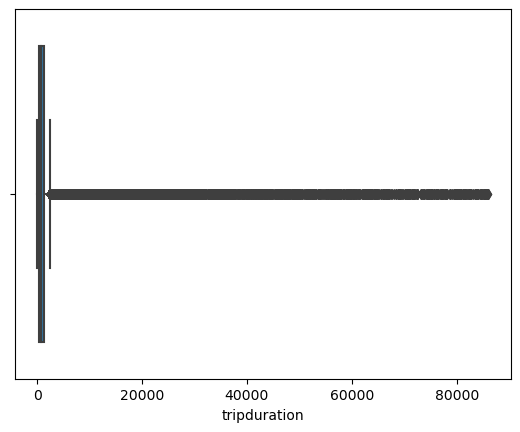

In [64]:
print(sb.boxplot(df_Q3['tripduration']))

##### These graphs clearly show that there outliers skewing the data, and confirms our assumptions. For the purpose of our general insights, we will be removing outliers using the Inter Quartile Range, where we only keep the data that is within the 25th and 75th percintiles. Since in our project, we are also going to be finding the truck movements within this data, we will call the data without outliers "explore". 

In [65]:
q1 = df_Q3['tripduration'].quantile(0.25)
q3 = df_Q3['tripduration'].quantile(0.75)

IQR = q3 - q1

explore = df_Q3[~((df_Q3['tripduration'] < (q1 - 1.5 * IQR))
         |(df_Q3['tripduration'] > (q3 + 1.5 * IQR)))].reset_index(drop=True)


In [66]:
explore.shape

(1526787, 22)

In [67]:
#Look at trip durations
print("The max trip duration in Q3 is:", max(explore['tripduration']))
print("The max trip duration in Q3 is:",min(explore['tripduration']))
print("The range of trip duration in Q3 is:",max(explore['tripduration']) - min(explore['tripduration']))
print(" ")
print("The average trip duration in Q3 is:",explore['tripduration'].mean())
print("The median trip duration in Q3 is:", statistics.median(list(explore['tripduration'])))
print("The mode of the trip durations in Q3 is:", statistics.mode(list(explore['tripduration'])))
print("The standard devation of trip durations in Q3 is:", statistics.stdev(list(explore['tripduration'])))

print(" ")
print("The trip duration by user type in Q3 is",explore['tripduration'].groupby(explore['usertype']).mean())

The max trip duration in Q3 is: 2452
The max trip duration in Q3 is: 60
The range of trip duration in Q3 is: 2392
 
The average trip duration in Q3 is: 833.9868626075543
The median trip duration in Q3 is: 726
The mode of the trip durations in Q3 is: 372
The standard devation of trip durations in Q3 is: 500.8973741910067
 
The trip duration by user type in Q3 is usertype
Customer      1235.101295
Dependent     1148.666667
Subscriber     706.212639
Name: tripduration, dtype: float64


/Users/Temporary/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='tripduration', ylabel='Density'>

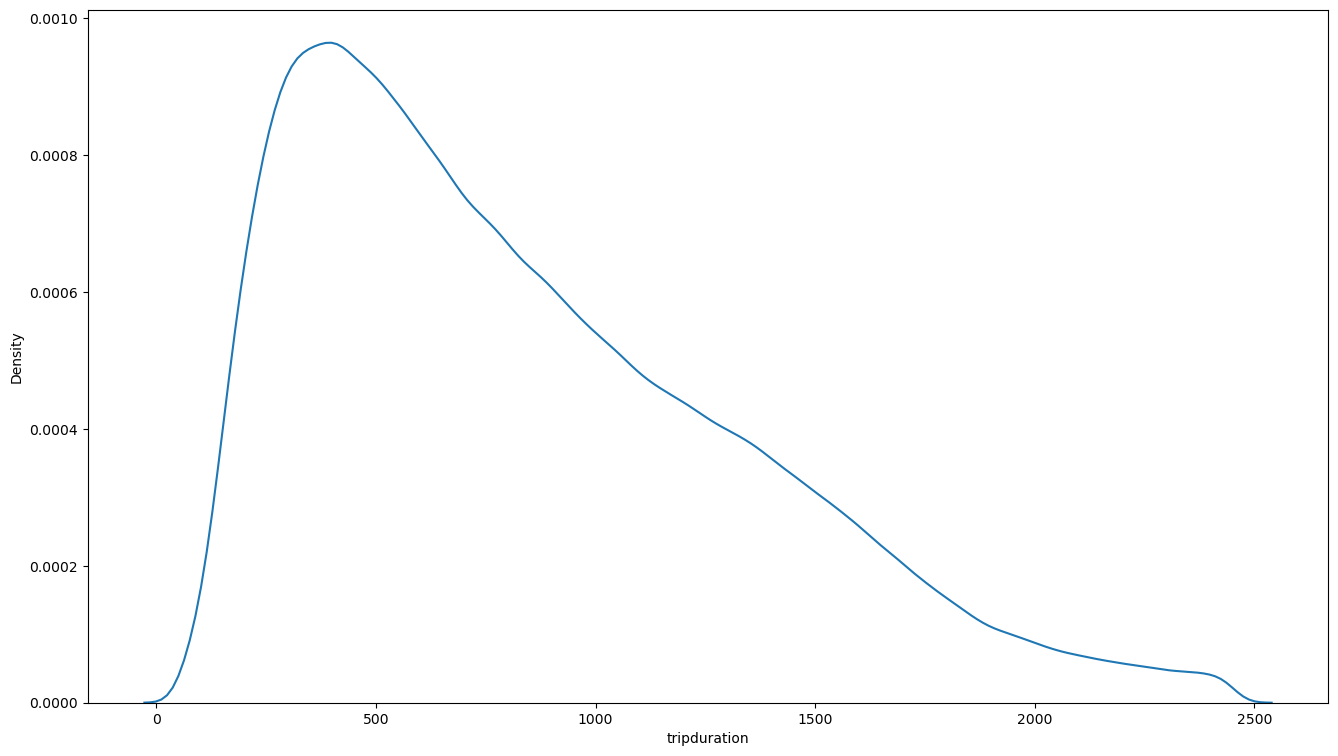

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sb.distplot(explore['tripduration'], hist=False, ax=ax)

In [69]:
# Shapiro-Wilk Test
from scipy.stats import shapiro

data = df_Q3['tripduration']
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.323, p=0.000
Sample does not look Gaussian (reject H0)


/Users/Temporary/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [70]:
# Shapiro-Wilk Test
from scipy.stats import shapiro

data = explore['tripduration']
# normality test
stat, p = shapiro(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.941, p=0.000
Sample does not look Gaussian (reject H0)


### Birthyear stats Q3

In [71]:
birthyear_insights = explore.dropna()

In [72]:
birthyear_insights

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,...,date,year,month,dayofmonth,hour,minute,months,weekend,dayofyear,dayofweek
0,16734065,2017-09-30 23:59:58,2017-10-01 00:05:47,1411,349,216,California Ave & Division St,259,California Ave & Francis Pl,Subscriber,...,2017-09-30,2017,9,30,23,59,Sep,1,273,Sat
1,16734064,2017-09-30 23:59:53,2017-10-01 00:05:47,3048,354,216,California Ave & Division St,259,California Ave & Francis Pl,Subscriber,...,2017-09-30,2017,9,30,23,59,Sep,1,273,Sat
2,16734063,2017-09-30 23:59:06,2017-10-01 00:02:52,2590,226,141,Clark St & Lincoln Ave,144,Larrabee St & Webster Ave,Subscriber,...,2017-09-30,2017,9,30,23,59,Sep,1,273,Sat
4,16734061,2017-09-30 23:58:47,2017-10-01 00:07:37,1287,530,96,Desplaines St & Randolph St,217,Racine Ave (May St) & Fulton St,Subscriber,...,2017-09-30,2017,9,30,23,58,Sep,1,273,Sat
5,16734060,2017-09-30 23:58:45,2017-10-01 00:16:37,6132,1072,478,Rockwell St & Eastwood Ave,117,Wilton Ave & Belmont Ave,Subscriber,...,2017-09-30,2017,9,30,23,58,Sep,1,273,Sat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526782,14853218,2017-07-01 00:01:28,2017-07-01 00:20:18,5647,1130,299,Halsted St & Roscoe St,176,Clark St & Elm St,Subscriber,...,2017-07-01,2017,7,1,0,1,Jul,1,182,Sat
1526783,14853217,2017-07-01 00:01:23,2017-07-01 00:16:54,5802,931,240,Sheridan Rd & Irving Park Rd,347,Ashland Ave & Grace St,Subscriber,...,2017-07-01,2017,7,1,0,1,Jul,1,182,Sat
1526784,14853216,2017-07-01 00:01:20,2017-07-01 00:18:03,3466,1003,35,Streeter Dr & Grand Ave,47,State St & Kinzie St,Subscriber,...,2017-07-01,2017,7,1,0,1,Jul,1,182,Sat
1526785,14853215,2017-07-01 00:00:34,2017-07-01 00:20:15,4224,1181,28,Larrabee St & Menomonee St,25,Michigan Ave & Pearson St,Subscriber,...,2017-07-01,2017,7,1,0,0,Jul,1,182,Sat


In [73]:
print("Q3")
print("The max birthyear in Q3 is:", max(birthyear_insights['birthyear']))
print("The max birthyear in Q3 is:",min(birthyear_insights['birthyear']))
print("The range of birthyears in Q3 is:",max(birthyear_insights['birthyear']) - min(birthyear_insights['birthyear']))
print(" ")
print("The average birthyear in Q3 is:",birthyear_insights['birthyear'].mean())
print("The average age in Q3:",2017 - birthyear_insights['birthyear'].mean())
print("The median trip duration in Q3 is:", statistics.median(list(birthyear_insights['birthyear'])))
print("The mode of the trip durations in Q3 is:", statistics.mode(list(birthyear_insights['birthyear'])))
print("The standard devation of trip durations in Q3 is:", statistics.stdev(list(birthyear_insights['birthyear'])))

print(" ")
print("The trip duration by user type in Q3 is",birthyear_insights['birthyear'].groupby(birthyear_insights['usertype']).mean())


Q3
The max birthyear in Q3 is: 2017.0
The max birthyear in Q3 is: 1899.0
The range of birthyears in Q3 is: 118.0
 
The average birthyear in Q3 is: 1982.3951665335549
The average age in Q3: 34.60483346644514
The median trip duration in Q3 is: 1986.0
The mode of the trip durations in Q3 is: 1989.0
The standard devation of trip durations in Q3 is: 10.634270621021953
 
The trip duration by user type in Q3 is usertype
Customer      1982.655647
Subscriber    1982.395085
Name: birthyear, dtype: float64


(array([  1.31000000e+02,   0.00000000e+00,   5.80000000e+01,
          0.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   5.00000000e+01,   2.70000000e+02,
          7.80000000e+01,   1.20000000e+01,   0.00000000e+00,
          4.30000000e+01,   3.30000000e+01,   8.50000000e+01,
          0.00000000e+00,   2.96000000e+02,   2.16000000e+02,
          1.79000000e+02,   1.83800000e+03,   1.24600000e+03,
          2.87500000e+03,   8.67700000e+03,   8.54500000e+03,
          1.28510000e+04,   2.55390000e+04,   2.02530000e+04,
          3.30040000e+04,   2.34650000e+04,   2.71230000e+04,
          4.09720000e+04,   2.91050000e+04,   3.37300000e+04,
          6.71190000e+04,   6.13320000e+04,   7.68030000e+04,
          1.55984000e+05,   1.26530000e+05,   2.10851000e+05,
          1.27177000e+05,   5.06270000e+04,   1.75740000e+04,
          1.98600000e+03,   2.10000000e+02,   1.11000000e+02,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

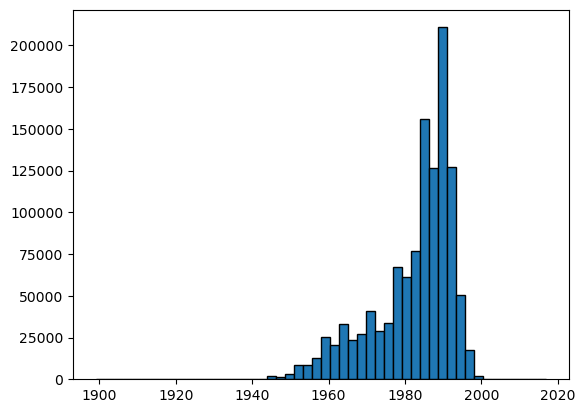

In [74]:
plt.hist(df_Q3['birthyear'],edgecolor='black', bins = 50)

##### From this, we can  observe that the general users are born between 1980 and 2000, and the average age is 34 years old. However, we also found that there were invalid inputs within the age, such as 1899 and 2017. These years do not make sense since ti would mean that someone over 100 and less than 1 is riding a bike. Therefore, we will disregard all observation where the birthyear is less than 1917 (older than 100) or 2016 (less than 1).It is important to note that this is simply an error from the user, and the real user probably is not this age. We will only drop these values for the purpose of our age inights, and we will keep them when looking at demand.

In [75]:
#Get rid of birth years where the year is less than 1918 and greater than 2016
birthyear_insights1 = birthyear_insights[~((birthyear_insights['birthyear'] < 1918) |(birthyear_insights['birthyear'] > 2016))]

In [76]:
print("Q3")
print("The max birthyear in Q3 is:", max(birthyear_insights1['birthyear']))
print("The max birthyear in Q3 is:",min(birthyear_insights1['birthyear']))
print("The range of birthyears in Q3 is:",max(birthyear_insights1['birthyear']) - min(birthyear_insights1['birthyear']))
print(" ")
print("The average birthyear in Q3 is:",birthyear_insights1['birthyear'].mean())
print("The average age in Q3:",2017 - birthyear_insights1['birthyear'].mean())
print("The median birthyear in Q3 is:", statistics.median(list(birthyear_insights1['birthyear'])))
print("The mode birthyear in Q3 is:", statistics.mode(list(birthyear_insights1['birthyear'])))
print("The standard devation of birthyears in Q3 is:", statistics.stdev(list(birthyear_insights1['birthyear'])))

print(" ")
print("The trip duration by user type in Q3 is",birthyear_insights1['birthyear'].groupby(birthyear_insights1['usertype']).mean())


Q3
The max birthyear in Q3 is: 2016.0
The max birthyear in Q3 is: 1918.0
The range of birthyears in Q3 is: 98.0
 
The average birthyear in Q3 is: 1982.4108771687409
The average age in Q3: 34.58912283125915
The median birthyear in Q3 is: 1986.0
The mode birthyear in Q3 is: 1989.0
The standard devation of birthyears in Q3 is: 10.576511820334904
 
The trip duration by user type in Q3 is usertype
Customer      1982.655647
Subscriber    1982.410800
Name: birthyear, dtype: float64


##### As can be seen from the stats above, the ages genrally follow normal distribution, this can be seen with the CLT and how the mean, median, and mode are relatively close to each other.

In [77]:
customer = df_Q3[df_Q3['usertype'] == "Customer"]

In [78]:
customer['tripduration'].mean()

1851.2612884745586

In [79]:
explore['usertype'].value_counts()

Subscriber    1157930
Customer       368854
Dependent           3
Name: usertype, dtype: int64

### Q3 - User Type Insights

In [80]:
#See unique values and their counts 
explore['usertype'].value_counts()

Subscriber    1157930
Customer       368854
Dependent           3
Name: usertype, dtype: int64

##### Here the "dependent" usertype does not make sense within the data, so we have decided to drop it. Statistically, it won't have any significnace given the proportion of dependent rows (3) to the rest of the data frame.

In [81]:
#This code drops the Dependent rows
explore1 = explore[~(explore['usertype'] == "Dependent")]

In [82]:
usertypes = pd.DataFrame(explore1['usertype'].value_counts())
usertypes

,usertype
Subscriber,1157930
Customer,368854


<AxesSubplot:ylabel='usertype'>

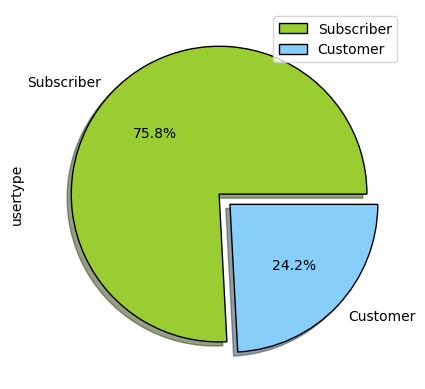

In [83]:
explode = [0.001, 0.1]
bar_cols = ['yellowgreen', 'lightskyblue']
usertypes.plot.pie(y = 'usertype', autopct='%1.1f%%', colors = bar_cols, explode=explode, shadow = True)

##### From this pie chart, we can see the distribution of usertypes in Q3 after removing outliers. Approximately 3 quarters of the users are subscribers, while one fourth are customers. 

In [84]:
gender = pd.DataFrame(explore['gender'].value_counts())
gender

,gender
Male,845685
Female,312490


<AxesSubplot:ylabel='gender'>

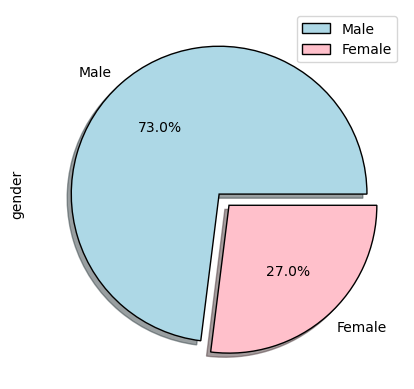

In [85]:
explode = [0.001, 0.1]
bar_cols = ['lightblue', 'pink']
gender.plot.pie(y = 'gender', autopct='%1.1f%%', colors = bar_cols, explode=explode, shadow = True)

##### From this gender pie chart, we can see that there is a majority of Male riders, with 73% of riders in Q3 being male. Now, lets try to find the gender split within the usertypes.

In [86]:
 demographics1 = pd.DataFrame(explore1.groupby(["usertype", "gender"])["trip_id"].count()).reset_index()

In [87]:
demographics1

,usertype,gender,trip_id
0,Customer,Female,57
1,Customer,Male,306
2,Subscriber,Female,312433
3,Subscriber,Male,845379


In [88]:
cust = demographics1[demographics1['usertype']=="Customer"]
sub = demographics1[demographics1['usertype']=="Subscriber"]

sub

,usertype,gender,trip_id
2,Subscriber,Female,312433
3,Subscriber,Male,845379


In [89]:
#Creating a new column in the data to have the coutns as a percentage of the sum for Customer user types
perc1 = []
for i in cust['trip_id']:
    perc = (i/sum(cust['trip_id']))*100
    perc1.append(perc)
    
cust['percent1'] = perc1
cust = cust.drop(columns=['trip_id'])
cust

/var/folders/qm/t91cfm1j3778c8mckf0kqlb80000gp/T/ipykernel_7574/3542706772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust['percent1'] = perc1


,usertype,gender,percent1
0,Customer,Female,15.702479
1,Customer,Male,84.297521


In [90]:
#Creating a new column in the data to have the coutns as a percentage of the sum for Subscriber user types
perc2 = []
for i in sub['trip_id']:
    perc = (i/sum(sub['trip_id']))*100
    perc2.append(perc)
    
sub['percent1'] = perc2
sub = sub.drop(columns=['trip_id'])
sub

/var/folders/qm/t91cfm1j3778c8mckf0kqlb80000gp/T/ipykernel_7574/1474445314.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['percent1'] = perc2


,usertype,gender,percent1
2,Subscriber,Female,26.984778
3,Subscriber,Male,73.015222


In [91]:
gender_usertype = pd.concat([cust, sub], ignore_index=True, axis=0)
gender_usertype

,usertype,gender,percent1
0,Customer,Female,15.702479
1,Customer,Male,84.297521
2,Subscriber,Female,26.984778
3,Subscriber,Male,73.015222


[Text(0.5, 1.0, 'Gender per usertype')]

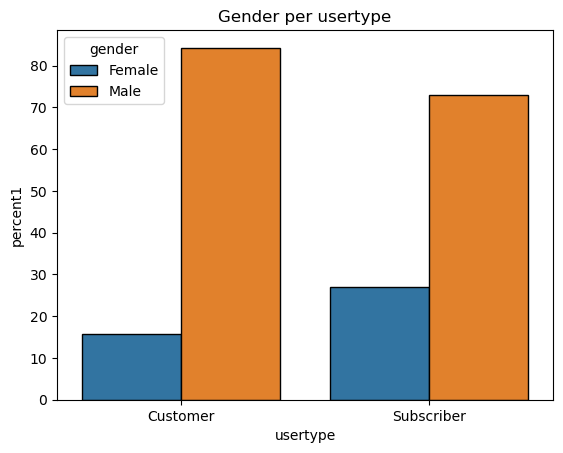

In [92]:
sb.barplot(data=gender_usertype, x="usertype", y="percent1", hue="gender").set(title='Gender per usertype')


##### As can be seen in the above bar plot, even when looking into gender within each usertype, there is still a majority of male users, however there is a higher proportion of female riders in the subsciber group.

In [93]:
avg_tripduration = pd.DataFrame(explore1.groupby(["usertype"])["tripduration"].mean()).reset_index()
avg_tripduration

,usertype,tripduration
0,Customer,1235.101295
1,Subscriber,706.212639


[Text(0.5, 1.0, 'Average trip duration per usertype')]

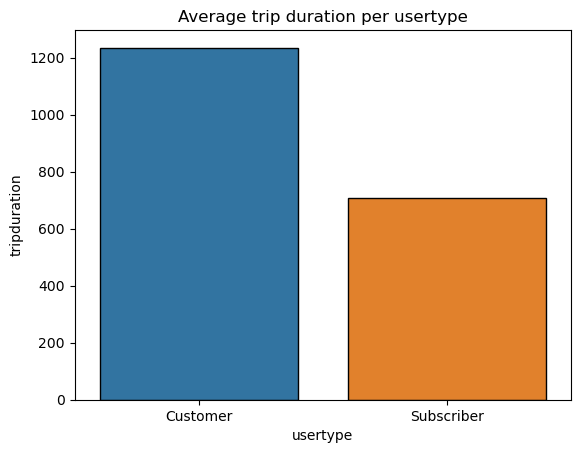

In [94]:
sb.barplot(data=avg_tripduration, x="usertype", y="tripduration").set(title='Average trip duration per usertype')

##### Here we can also see that the average trip duration for customers is nearly double the duration for subscribers

In [95]:
#Merging the longitude and latitude to the main dataframe
df_Q3_total = explore1.merge(df_geo, how='inner', left_on='from_station_name', right_on='name').merge(df_geo, how='inner', left_on='to_station_name', right_on='name', suffixes=['_from', '_to']) .drop_duplicates()

In [96]:
#Here we can see that they have been added
df_Q3_total.columns

Index(['trip_id', 'start_time', 'end_time', 'bikeid', 'tripduration',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear', 'date', 'year',
       'month', 'dayofmonth', 'hour', 'minute', 'months', 'weekend',
       'dayofyear', 'dayofweek', 'id_from', 'name_from', 'city_from',
       'latitude_from', 'longitude_from', 'dpcapacity_from',
       'online_date_from', 'id_to', 'name_to', 'city_to', 'latitude_to',
       'longitude_to', 'dpcapacity_to', 'online_date_to'],
      dtype='object')

In [97]:
#Creating a route_id, so looking at the start and end location of each trip
df_Q3_total['route_id'] = df_Q3_total.apply(lambda x: '{0}-{1}'.format(int(x['from_station_id']), int(x['to_station_id'])), axis=1)

In [98]:
# Extract the unique routes from the data with their start and end coordinates
maps = df_Q3_total[['route_id', 'from_station_id', 'latitude_from', 'longitude_from', 'to_station_id', 'latitude_to', 'longitude_to']].drop_duplicates()
maps['Distance'] = maps.apply(lambda x: distance.distance((x['latitude_from'], x['longitude_from']), (x['latitude_to'], x['longitude_to'])).km * 1000, axis=1)

# Merge the distance calculation with the main DataFrame
df_Q3_total = df_Q3_total.merge(maps[['route_id', 'Distance']], how='left', on='route_id')
df_Q3_total = df_Q3_total[[x for x in df_Q3_total.columns if not 'from' in x and not 'to' in x and x != 'route_id']]

/Users/Temporary/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/Temporary/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/Temporary/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

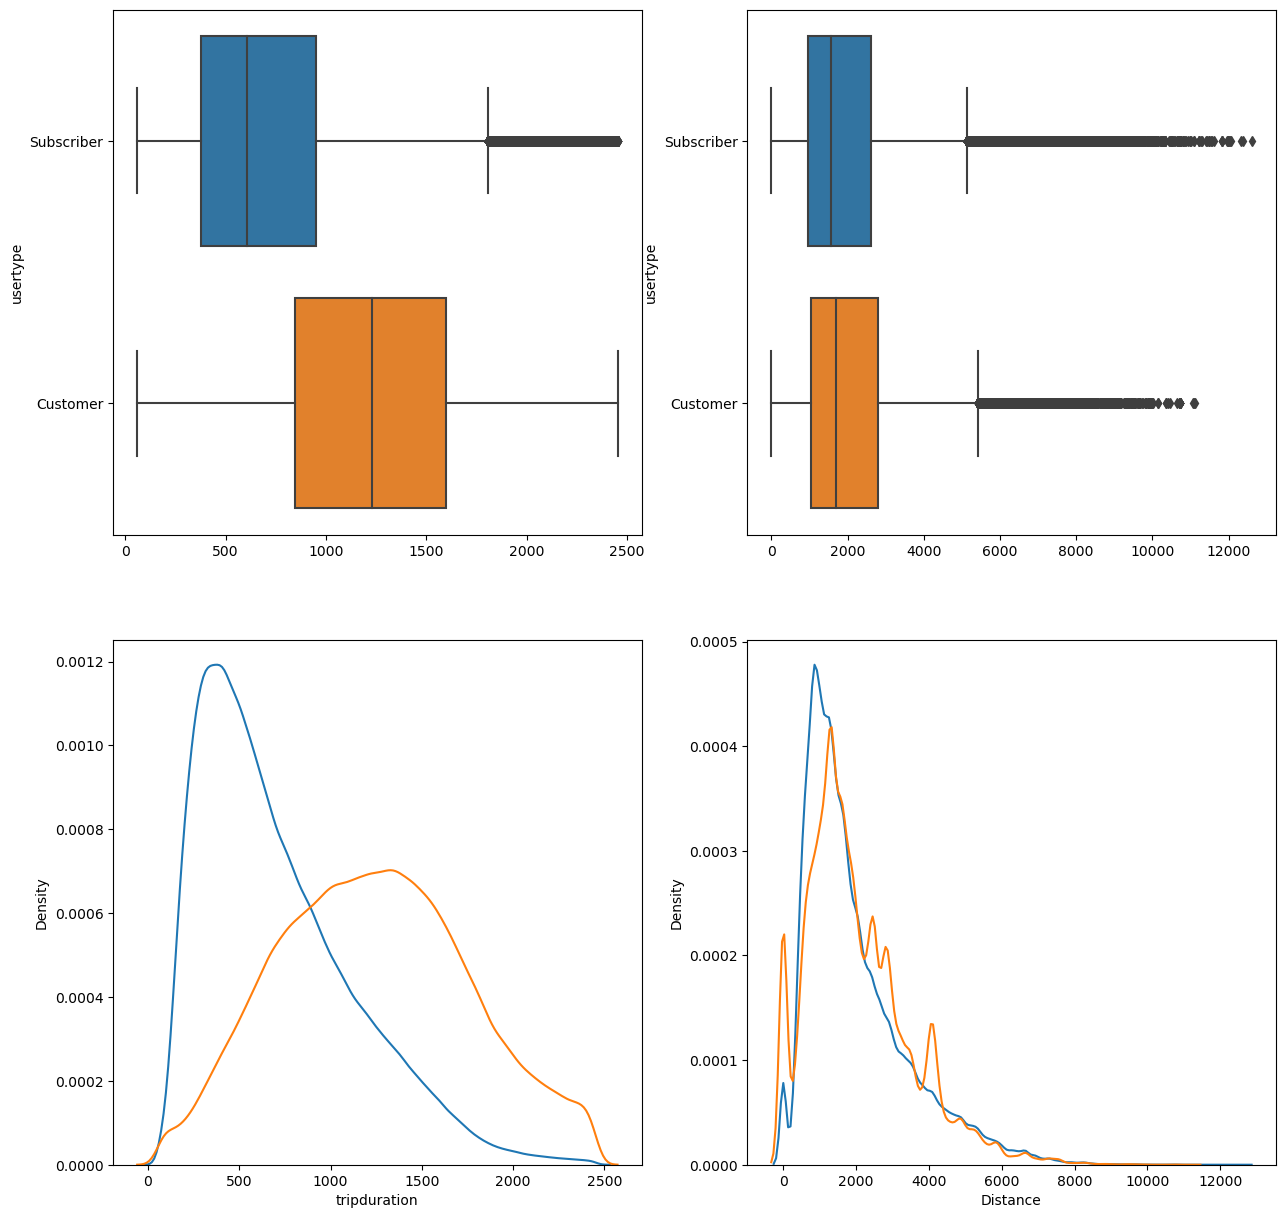

In [99]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15, 15))
for i, col in enumerate(['tripduration', 'Distance']):
    # Graph the distribution plots (seaborn doesn't allow default separation for distplot)
    for j, user in enumerate(df_Q3_total['usertype'].unique()):
        sb.distplot(df_Q3_total[df_Q3_total['usertype']==user][col], hist=False, ax=ax2[i])
    
    # Graph the boxplots
    sb.boxplot(x=col, y='usertype', data=df_Q3_total, ax=ax1[i])

    ax1[i].set_xlabel('')

In [100]:
#Creating a sunburst chart
sunburst = df_Q3.groupby(['gender', 'months','dayofweek'], as_index=False).agg({'tripduration': 'mean'}) #This is to group the data to have both genders, 
                                                                                                         #and the avg trip duration per day and month
#Creating a sunburst visualiztion using plotly.express
tripduration_burst = px.sunburst(sunburst, path = ['gender', 'months', 'dayofweek'], 
                        values = 'tripduration',
                        color = 'tripduration',
                        color_continuous_scale = 'blues',
                        maxdepth = -1)

tripduration_burst.update_layout(margin = dict(t = 10, b = 10, r = 10, l = 10),
                                showlegend = False,
                                plot_bgcolor = 'black',
                                )
                  
tripduration_burst.show()

From this sunburst visualizaiton, we can see the average trip durations by the dark blue colors. Therefore, we can see that the longest rides are on staturdays in July, from Female riders. Furthermore, in general, trip duration increases on the weekend for both genders

### Demand Related Insights and Visualizations

Text(0, 0.5, 'Average Hourly Trips')

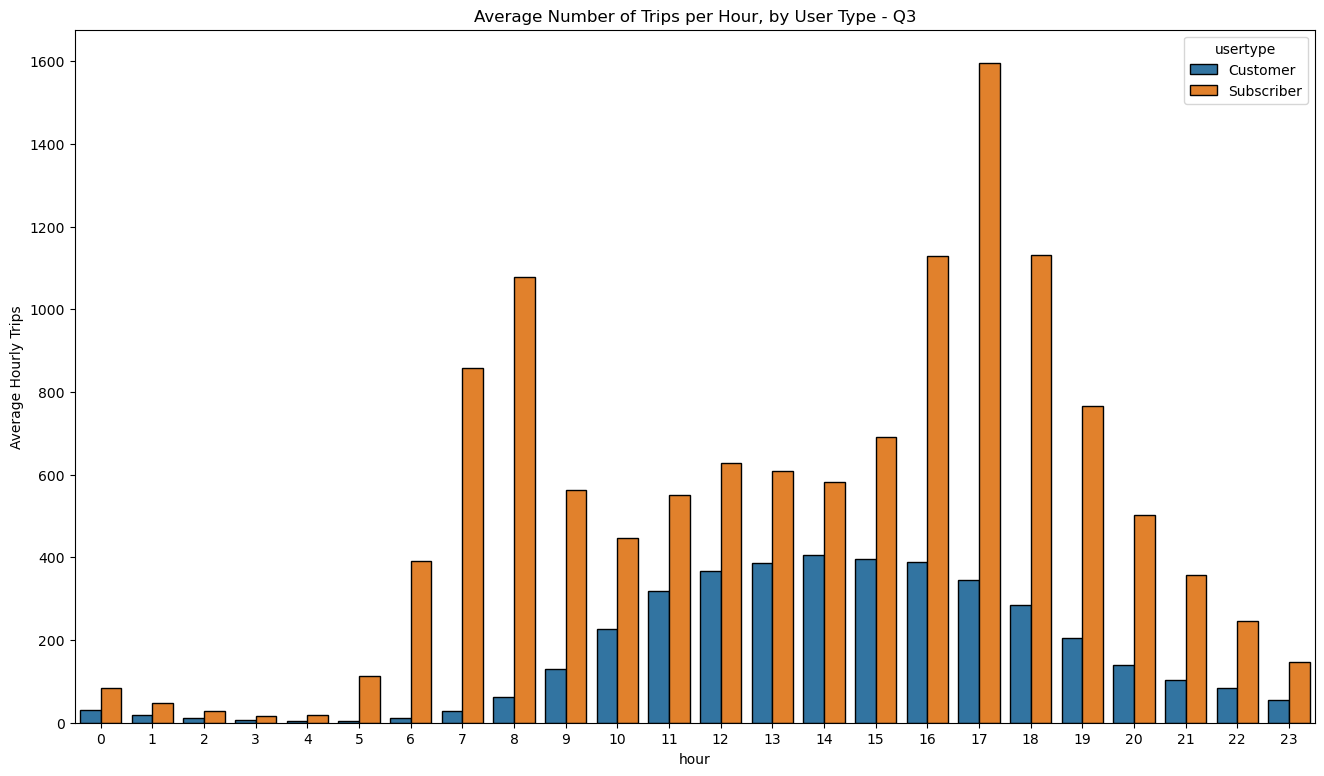

In [101]:
data = df_Q3_total.groupby(['date', 'hour', 'usertype'])['trip_id'].nunique().groupby(['hour', 'usertype']).mean().reset_index()
fig, ax = plt.subplots(figsize=(16, 9))

sb.barplot(x='hour', y='trip_id', hue='usertype', data=data, ax=ax)
ax.set_title('Average Number of Trips per Hour, by User Type - Q3')
ax.set_ylabel('Average Hourly Trips')

This graph illustrates the average number of trips per hour for each user type (subscribers vs non-subscribers/customers). Interestingly, the non-subscribers follow a normal distribution with a peak at 14:00 because there is more randomness throughout the day. Also, 14:00 is an ideal time for users to use bikes for leisure because that’s when the weather cools down from noon. Whereas the subscribers follow a binomial distribution having peaks at 8:00 and 17:00. This is because if we assume that most people follow a 9:00 to 17:00 job, they would leave their homes between 8:00 and 9:00, thus having a peak at 8:00, and leave their workplace at 17:00, thus having a peak at 17:00. Nevertheless, we also see greater usage at 17:00, nearly 50% larger than the usage at 8:00. Moreover, throughout the entire day and regardless of time, subscribers have always used the bikes more than the non-subscribers. We can allude this to the fact that the total number of subscribers is nearly 3 times the total number of non-subscribers (72.5% of subscribers compared to 27.5% of non-subscribers). 



<AxesSubplot:xlabel='dayofweek'>

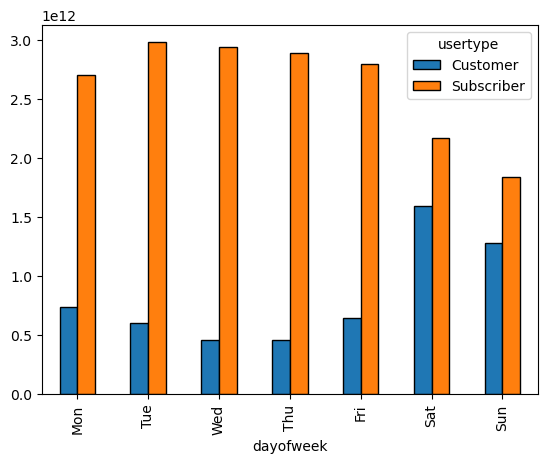

In [102]:
df_grouped = df_Q3_total.groupby(['usertype', 'dayofweek']).sum().trip_id.reset_index()
df_pivot = df_grouped.pivot('dayofweek','usertype','trip_id').reset_index()

weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
mapping = {day: i for i, day in enumerate(weekdays)}
key = df_pivot['dayofweek'].map(mapping)    
df_pivot = df_pivot.iloc[key.argsort()]

df_pivot.plot(kind='bar', x='dayofweek')

This graph shows the average daily trips for Q3 with the X-axis being the days of the week and the y-axis is the count. In this graph we compared the average daily trips of subscribers and customers (non-subscribers) and we can clearly see a difference of usage in the days of the week and total amount of usage. Overall, subscribers use the bikes more on a daily basis with around 170 to 180 of the bikes being used on weekdays. However, on the weekends the average daily trips for subscribers fall and nearly becomes on par with non-subscribers. We allude this to the fact that subscribers mostly use the bikes for trips to work and back on weekdays. Compared to subscribers, non-subscribers are the opposite. Non-subscribers use the bikes mostly on the weekends with a nearly 100% increase from the average of the workweek. There is a general decline till Thursday and starts increasing from Friday (half of the day is a weekend) and peaks on Saturday with around 100 bike ID’s being used. 


##### Since we are now looking at demand, we are switching back to our original dataset which inclides the afformentioned outliers

In [103]:
#Finding #Finding the top 10 "From" stations based on the number of recorded trips

df_StartStation_Count = pd.DataFrame(df_Q3['from_station_name'].value_counts().reset_index(name = 'Counts'))
df_StartStation_Count.columns = ['from_station_name', 'Counts']
df_top10s = df_StartStation_Count.head(10)
df_top10s

,from_station_name,Counts
0,Streeter Dr & Grand Ave,52110
1,Lake Shore Dr & Monroe St,26507
2,Lake Shore Dr & North Blvd,26342
3,Theater on the Lake,26251
4,Michigan Ave & Oak St,20673
5,Canal St & Adams St,20231
6,Clinton St & Washington Blvd,17171
7,Millennium Park,16260
8,Clinton St & Madison St,15967
9,Shedd Aquarium,15864


In [104]:
#Finding the top 10 "to" stations based on the number of recorded trips
df_EndStation_Count = pd.DataFrame(df_Q3['to_station_name'].value_counts().reset_index(name = 'Counts'))
df_EndStation_Count.columns = ['to_station_name', 'Counts']
df_top10e = df_EndStation_Count.head(10)
df_top10e

,to_station_name,Counts
0,Streeter Dr & Grand Ave,56631
1,Lake Shore Dr & North Blvd,29650
2,Theater on the Lake,27759
3,Lake Shore Dr & Monroe St,25005
4,Michigan Ave & Oak St,22102
5,Canal St & Adams St,20703
6,Millennium Park,18441
7,Clinton St & Madison St,17198
8,Clinton St & Washington Blvd,15953
9,Shedd Aquarium,15120


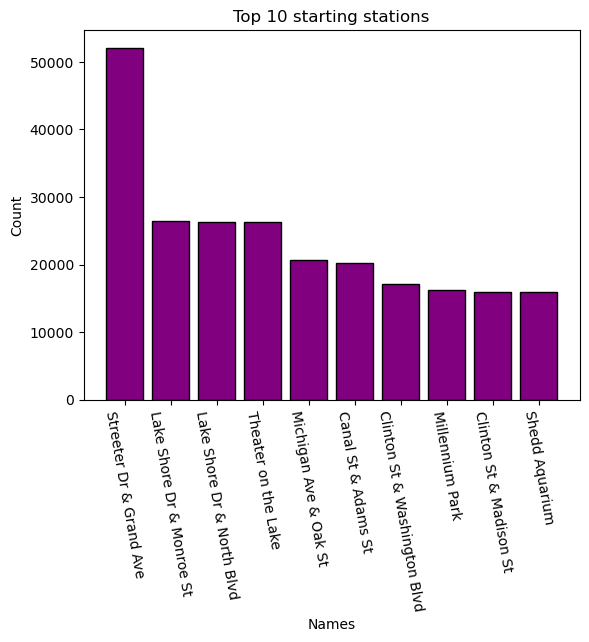

In [105]:
x_axis = df_top10s['from_station_name']
y_axis = df_top10s['Counts']

#plt.figure(figsize=(10,10))
plt.xticks(rotation=280)
#ax = plt.axes()
#ax.set_facecolor("lightgrey")

plt.bar(x_axis, y_axis, color='Purple', label=df_top10s['Counts'])
plt.title('Top 10 starting stations')
plt.xlabel('Names')
plt.ylabel('Count')
plt.show()

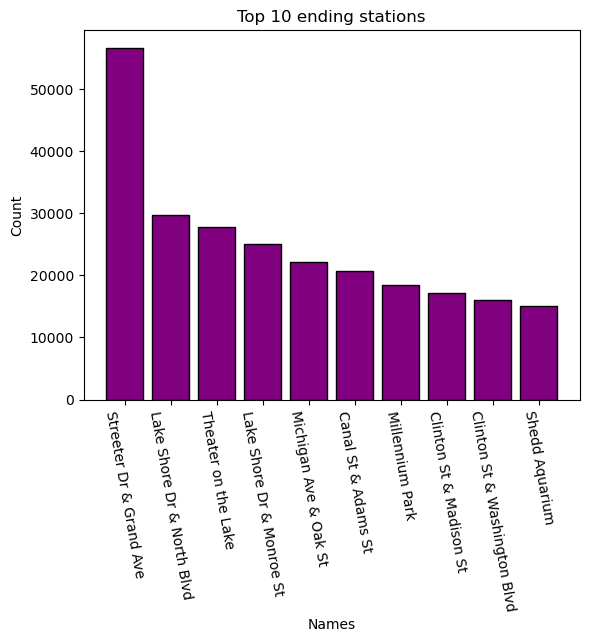

In [106]:
#Top 10 ending stations
x_axis = df_top10e['to_station_name']
y_axis = df_top10e['Counts']

#plt.figure(figsize=(10,10))
plt.xticks(rotation=280)


plt.bar(x_axis, y_axis, color='Purple')
plt.title('Top 10 ending stations')
plt.xlabel('Names')
plt.ylabel('Count')
plt.show()

In [107]:
#Finding the most popular routes in Q3
PopularRoutes = df_Q3[["from_station_name", "to_station_name"]]
PopularRoutes['popular_routes'] = df_Q3['from_station_name'] + ' TO ' + df_Q3['to_station_name']
PopularRoutes = pd.DataFrame(PopularRoutes['popular_routes'].value_counts().reset_index(name = 'Counts'))
PopularRoutes.sort_values(by = 'Counts', ascending  = False, inplace = True)
PopularRoutes = PopularRoutes.head(10)
PopularRoutes

/var/folders/qm/t91cfm1j3778c8mckf0kqlb80000gp/T/ipykernel_7574/3559174800.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,index,Counts
0,Lake Shore Dr & Monroe St TO Streeter Dr & Gra...,6307
1,Streeter Dr & Grand Ave TO Streeter Dr & Grand...,5379
2,Streeter Dr & Grand Ave TO Lake Shore Dr & Nor...,4540
3,Streeter Dr & Grand Ave TO Theater on the Lake,4508
4,Lake Shore Dr & North Blvd TO Streeter Dr & Gr...,4053
5,Theater on the Lake TO Streeter Dr & Grand Ave,3981
6,Streeter Dr & Grand Ave TO Lake Shore Dr & Mon...,3749
7,Streeter Dr & Grand Ave TO Michigan Ave & Oak St,2692
8,Lake Shore Dr & Monroe St TO Lake Shore Dr & M...,2435
9,Michigan Ave & Oak St TO Streeter Dr & Grand Ave,2381


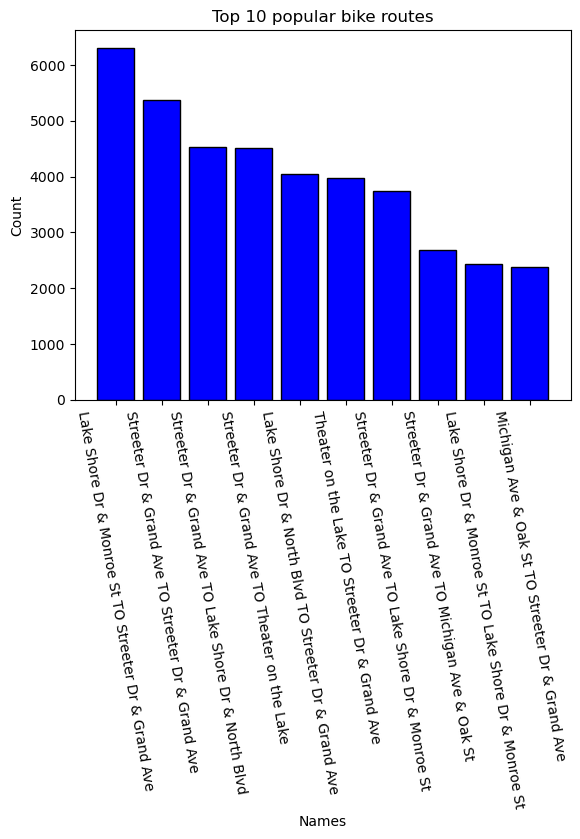

In [108]:
#Top 10 ending stations
x_axis = PopularRoutes['index']
y_axis = PopularRoutes['Counts']

#plt.figure(figsize=(10,10))
plt.xticks(rotation=280)


plt.bar(x_axis, y_axis, color='Blue')
plt.title('Top 10 popular bike routes')
plt.xlabel('Names')
plt.ylabel('Count')
plt.show()

In [109]:
stationArr = np.array(df_geo[['latitude', 'longitude']])

# plot heatmap
m = folium.Map([41.8781, -87.6298], zoom_start=11)
m.add_children(plugins.HeatMap(stationArr, radius=15))
m

/var/folders/qm/t91cfm1j3778c8mckf0kqlb80000gp/T/ipykernel_7574/2786297652.py:5: FutureWarning:

Method `add_children` is deprecated. Please use `add_child` instead.



In [110]:
both_quarters=Table.read_table("Divvy_Stations_2017_Q3Q4.csv")
quarter_three=Table.read_table("Divvy_Trips_2017_Q3.csv")

#Here we are making functions for some more advanced visualizations
from datetime import date
from datetime import time
def time_f (s_cell):  #This function splits the time section of the start_time and end_time columns by hour, minute, and second
    split_cell=s_cell.split()
    time_data=split_cell[1]
    time_data=time_data.split(':') #We use ":" as the delimiter sicne the time section is split by ":" in the data
    #print(time_data)
    time_data[0]=int(time_data[0])
    time_data[1]=int(time_data[1])
    time_data[2]=int(time_data[2])
    time_data=time(time_data[0],time_data[1],time_data[2])
    return time_data;


In [111]:
def date_f (s_cell): #This function splits the date section of the start/end_time columns. 
    split_cell=s_cell.split()
    date_data=split_cell[0]
    date_data=date_data.split('/') #Using "/" as the delimiter 
    date_data=date(int(date_data[2]),int(date_data[0]),int(date_data[1])) #Here we are splitting it by year, month, day
    return date_data;

In [112]:
#Here we are applying the previous functions to split the time and date data from the original table. 
quarter_three=quarter_three.with_column('Start-Time',quarter_three.apply(time_f,'start_time'))
quarter_three=quarter_three.with_column('Start-Date',quarter_three.apply(date_f,'start_time'))
quarter_three=quarter_three.with_column('End-Time',quarter_three.apply(time_f,'end_time'))
quarter_three=quarter_three.with_column('End-Date',quarter_three.apply(date_f,'end_time'))

In [113]:
#This gives us a small table only containing the specific date that we are looking for 
def day_info (quarter_three,year,month,day):
    f_day=quarter_three.where('Start-Date',date(year,month,day))
    f_day=f_day.sort("Start-Time",descending=False)

    hour_column=make_array([])
    for i in range (f_day.num_rows):
        hour_v=f_day['Start-Time'][i].hour
        hour_column=np.append(hour_column,hour_v)

    f_day=f_day.with_column("Start-hour",hour_column)

    minute_column= make_array([])
    half_hour_col = make_array([])

    for i in range (f_day.num_rows):
        minute_v=f_day['Start-Time'][i].minute
        minute_column=np.append(minute_column,minute_v)

    f_day=f_day.with_column("Start-minutes",minute_column)
    for i in range (f_day.num_rows):
        if f_day['Start-minutes'][i]<=30:
            half_hour_col=np.append(half_hour_col,50)
        if f_day['Start-minutes'][i]>30:
            half_hour_col=np.append(half_hour_col,100)
    
    f_day=f_day.with_column("Start_Half_hour",half_hour_col)
    
    hour_column=make_array([])
    for i in range (f_day.num_rows):
        hour_v=f_day['End-Time'][i].hour
        hour_column=np.append(hour_column,hour_v)

    f_day=f_day.with_column("End-hour",hour_column)

    minute_column= make_array([])
    half_hour_col = make_array([])

    for i in range (f_day.num_rows):
        minute_v=f_day['End-Time'][i].minute
        minute_column=np.append(minute_column,minute_v)

    f_day=f_day.with_column("End-minutes",minute_column)
    for i in range (f_day.num_rows):
        if f_day['End-minutes'][i]<=30:
            half_hour_col=np.append(half_hour_col,50)
        if f_day['End-minutes'][i]>30:
            half_hour_col=np.append(half_hour_col,100)
    
    f_day=f_day.with_column("End_Half_hour",half_hour_col)
    
    f_day=f_day.drop('gender','birthyear','usertype_Subscriber','date','year','month','dayofmonth','hour','minute','months','dayofyear','dayofweek','season')
    
    return f_day

In [114]:
#This gives us a table with all of the start times to help us make visualizaitons
def plot_start (year, month, day):
    day=day_info(quarter_three,year,month,day)
    #print(type(day))
    plot_hours=([])
    for i in range(day.num_rows):
    
        if day['Start-hour'][i]!=0:
            if (day['Start_Half_hour'][i])==100:
                str_time=str(day['Start_Half_hour'][i]*(day['Start-hour'][i]+1))
            else:
                str_hour=str(day['Start-hour'][i])
                str_half=str(day['Start_Half_hour'][i])
                str_time=str_hour+str_half
        else:
            str_hour=str(day['Start-hour'][i])
            str_half=str(day['Start_Half_hour'][i])
            str_time=str_hour+str_half
        
        plot_hours=np.append(plot_hours,int(str_time))

    day=day.with_column('Start-Plot-hours',plot_hours)
    #print(type(day))
    return day

In [115]:
#This gives us a table with all of the end times to help us make visualizaitons
def plot_end (year, month, day):
    day=day_info(quarter_three,year,month,day)
    plot_hours=([])
    for i in range(day.num_rows):
    
        if day['End-hour'][i]!=0:
            if (day['End_Half_hour'][i])==100:
                str_time=str(day['End_Half_hour'][i]*(day['End-hour'][i]+1))
            else:
                str_hour=str(day['End-hour'][i])
                str_half=str(day['End_Half_hour'][i])
                str_time=str_hour+str_half
        else:
            str_hour=str(day['End-hour'][i])
            str_half=str(day['End_Half_hour'][i])
            str_time=str_hour+str_half
        
        plot_hours=np.append(plot_hours,int(str_time))

    day=day.with_column('End-Plot-hours',plot_hours)
    return day

In [116]:
#Creats a table fo the streets based on the input
def main_from_sts (year,month,day,stations):
    f_day=plot_start(year, month, day)
    fr_station=f_day.group('from_station_id').sort('count',descending=True)
    main_fr_stations=fr_station['from_station_id'][np.arange(stations)]
    f_fr=f_day.where('from_station_id',main_fr_stations[0])
    for i in range (1,stations):
        f_day_f=f_day.where('from_station_id',main_fr_stations[i])
        f_fr.append(f_day_f.take(np.arange(f_day_f.num_rows)))    
    f_fr=f_fr.group(['from_station_id','Start-Plot-hours'])
    b=([]) 
    for i in range(f_fr.num_rows):
        for j in main_fr_stations:
            if f_fr['from_station_id'][i]==j:
                a=(f_fr['count'][i])/(capacity.where('id',j)['dpcapacity'])
                b=np.append(b,a)
    f_fr=f_fr.with_column('Percentages',b)
    return f_fr


In [117]:
#Here we are calculating the proprtional percentage of bikes that left the station based on the station capacity
def main_to_sts (year,month,day,stations):
    t_day=plot_end(year, month, day)
    to_station=t_day.group('to_station_id').sort('count',descending=True)
    main_to_stations=to_station['to_station_id'][np.arange(stations)]
    t_to=t_day.where('to_station_id',main_to_stations[0])
    for i in range (1,stations):
        t_day_t=t_day.where('to_station_id',main_to_stations[i])
        t_to.append(t_day_t.take(np.arange(t_day_t.num_rows)))
    t_to=t_to.group(['to_station_id','End-Plot-hours'])
    b=([]) 
    for i in range(t_to.num_rows):
        for j in main_to_stations:
            if t_to['to_station_id'][i]==j:
                a=(t_to['count'][i])/(capacity.where('id',j)['dpcapacity'])
                b=np.append(b,a)
    t_to=t_to.with_column('Percentages',b)
    return t_to


In [118]:
capacity=both_quarters.drop('city','latitude','longitude','Unnamed: 7')

Text(0, 0.5, 'Percentage full capacity')

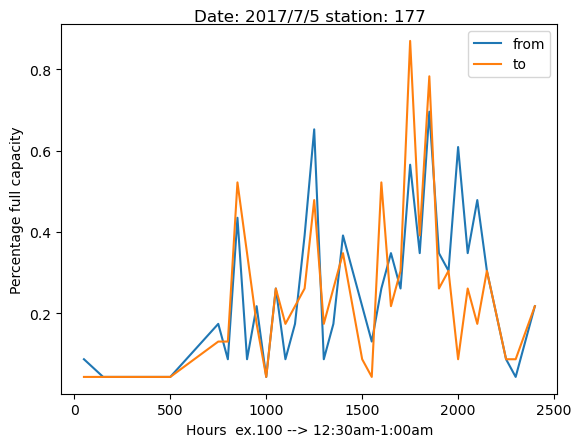

In [119]:
#Creating a graph of the inflows and outflows of a specific station id on a specific day
from_st=main_from_sts(2017,7,5,10)
gi=from_st.where('from_station_id',177)
to_st=main_to_sts(2017,7,5,10)
gi_out=to_st.where('to_station_id',177)
gi=gi.group('Start-Plot-hours',np.mean)
gi_out=gi_out.group('End-Plot-hours',np.mean)
#gi.show()
plt.plot(gi['Start-Plot-hours'],gi['Percentages mean'],label='177')
plt.plot(gi_out['End-Plot-hours'],gi_out['Percentages mean'],label='177')
plt.legend(["from",'to'])
plt.title(label='Date: '+str(2017)+'/'+str(7)+'/'+str(5)+" station: "+"177",fontweight=10, pad='2.0')
plt.xlabel('Hours  ex.100 --> 12:30am-1:00am')
plt.ylabel('Percentage full capacity')

In [121]:
bikes=plot_end(2017,7,3)
bikes=bikes.drop('Unnamed: 0','trip_id','start_time','end_time','weekend')
bikeids=bikes.group('bikeid')['bikeid']
for i in range(bikes.num_rows):
    if bikes['from_station_name'][i]=='Dearborn St & Van Buren St (*)':
        bikes=bikes.remove(i)
    if bikes['to_station_name'][i]=='Dearborn St & Van Buren St (*)':
        bikes=bikes.remove(i)
    if bikes['from_station_name'][i]=='Chicago Ave & Dempster St':
        bikes=bikes.remove(i)
    if bikes['to_station_name'][i]=='Chicago Ave & Dempster St':
        bikes=bikes.remove(i)
    if bikes['from_station_name'][i]=='Delano Ct & Roosevelt':
        bikes=bikes.remove(i)
    if bikes['to_station_name'][i]=='Delano Ct & Roosevelt':
        bikes=bikes.remove(i)
bikes=bikes.where('bikeid',331)
start_lon=([])
start_lat=([])
end_lon=([])
end_lat=([])
for i in range (bikes.num_rows):
    start_lon=np.append(start_lon,both_quarters.where('id',bikes['from_station_id'][i])['longitude'])
    start_lat=np.append(start_lat,both_quarters.where('id',bikes['from_station_id'][i])['latitude'])
    end_lon=np.append(end_lon,both_quarters.where('id',bikes['to_station_id'][i])['longitude'])
    end_lat=np.append(end_lat,both_quarters.where('id',bikes['to_station_id'][i])['latitude'])

bikes=bikes.with_columns('start_lon',start_lon)
bikes=bikes.with_columns('start_lat',start_lat)
bikes=bikes.with_columns('end_lon',end_lon)
bikes=bikes.with_columns('end_lat',end_lat)
bikes=bikes.drop('tripduration','from_station_id','to_station_id','trip_count','Start-Time','Start-Date','End-Time','End-Date','Start-hour','Start-minutes','Start_Half_hour','End-hour','End-minutes','End_Half_hour','End-Plot-hours')
bikes=bikes.with_column('Index',np.arange(bikes.num_rows))


From this graph we can see that the bike movements within a station generally follow each other, with the inflow and outflow generally being the same. THis is until 8:00 pm, where we see an opposite movement in inflows and outflows. We suspsect that this is due to truck movements. So we will now attempt to find the truck movements within the data

In [122]:
import plotly.graph_objects as go
#Without Truck movements

#Plotting the start and end longitude and latitude of a specific bike ID on a specific day. 
fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['start_lon'][0],bikes['end_lon'][0]],
    lat = [bikes['start_lat'][0],bikes['end_lat'][0]],
    marker = {'size': 10},
    name='0: '+bikes['from_station_name'][0]+' --> '+bikes['to_station_name'][0]))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['end_lon'][0],bikes['end_lon'][1]],
    lat = [bikes['end_lat'][0],bikes['end_lat'][1]],
    marker = {'size': 10},
    name='1: '+bikes['to_station_name'][0]+' --> '+bikes['to_station_name'][1]))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['end_lon'][1],bikes['end_lon'][2]],
    lat = [bikes['end_lat'][1],bikes['end_lat'][2]],
    marker = {'size': 10},
    name='2: '+bikes['to_station_name'][1]+' --> '+bikes['to_station_name'][2]))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['start_lon'][3],bikes['end_lon'][3]],
    lat = [bikes['start_lat'][3],bikes['end_lat'][3]],
    marker = {'size': 10},
    name='3: '+bikes['from_station_name'][3]+' --> '+bikes['to_station_name'][3]))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['end_lon'][3],bikes['end_lon'][4]],
    lat = [bikes['end_lat'][3],bikes['end_lat'][4]],
    marker = {'size': 10},
    name='4: '+bikes['to_station_name'][3]+' --> '+bikes['to_station_name'][4]))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['end_lon'][4],bikes['end_lon'][5]],
    lat = [bikes['end_lat'][4],bikes['end_lat'][5]],
    marker = {'size': 10},
    name='5: '+bikes['to_station_name'][4]+' --> '+bikes['to_station_name'][5]))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['end_lon'][5],bikes['end_lon'][6]],
    lat = [bikes['end_lat'][5],bikes['end_lat'][6]],
    marker = {'size': 10},
    name='6: '+bikes['to_station_name'][5]+' --> '+bikes['to_station_name'][6]))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['start_lon'][7],bikes['end_lon'][7]],
    lat = [bikes['start_lat'][7],bikes['end_lat'][7]],
    marker = {'size': 10},
    name='7: '+bikes['from_station_name'][7]+' --> '+bikes['to_station_name'][7]))

fig.update_traces(ids=('hi','hello','bye','chiao'), selector=dict(type='scattermapbox'))
#fig.update_traces(legendgrouptitle=pname('1'), selector=dict(type='scattermapbox'))
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon':bikes['start_lon'][0] , 'lat':bikes['start_lat'][0]},
        'style': "carto-positron",
        'center': {'lon': bikes['start_lon'][0], 'lat': bikes['start_lat'][0]},
        'zoom': 11})

fig.show()

This graph presents an example of a bike movement and for this example we used BikeId 331 on 03/07/2017. As can be seen by the visualization the bike starts at Clark St & Armitage Ave and ends up in Sheridan Rd & Buena Ave in 7 bike trips. The connect lines show the bike trips from station to station by different bike users. However, 2 routes are not connected indicating that a truck must have moved the bike from one station to another and this can be seen in Graph/visualization 11.


In [123]:
#With Truck Movements
#Plotting the start and end longitude and latitude of a specific bike ID on a specific day. 
fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['start_lon'][0],bikes['end_lon'][0]],
    lat = [bikes['start_lat'][0],bikes['end_lat'][0]],
    marker = {'size': 10},
    name='0: '+bikes['from_station_name'][0]+' --> '+bikes['to_station_name'][0]))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['end_lon'][0],bikes['end_lon'][1]],
    lat = [bikes['end_lat'][0],bikes['end_lat'][1]],
    marker = {'size': 10},
    name='1: '+bikes['to_station_name'][0]+' --> '+bikes['to_station_name'][1]))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['end_lon'][1],bikes['end_lon'][2]],
    lat = [bikes['end_lat'][1],bikes['end_lat'][2]],
    marker = {'size': 10},
    name='2: '+bikes['to_station_name'][1]+' --> '+bikes['to_station_name'][2]))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['end_lon'][2],bikes['start_lon'][3]],
    lat = [bikes['end_lat'][2],bikes['start_lat'][3]],
    marker = {'size': 10},
    line = dict(
                width = 1,
                color = 'black'),
    name='Truck Movement 1#'))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['start_lon'][3],bikes['end_lon'][3]],
    lat = [bikes['start_lat'][3],bikes['end_lat'][3]],
    marker = {'size': 10},
    name='3: '+bikes['from_station_name'][3]+' --> '+bikes['to_station_name'][3]))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['end_lon'][3],bikes['end_lon'][4]],
    lat = [bikes['end_lat'][3],bikes['end_lat'][4]],
    marker = {'size': 10},
    name='4: '+bikes['to_station_name'][3]+' --> '+bikes['to_station_name'][4]))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['end_lon'][4],bikes['end_lon'][5]],
    lat = [bikes['end_lat'][4],bikes['end_lat'][5]],
    marker = {'size': 10},
    name='5: '+bikes['to_station_name'][4]+' --> '+bikes['to_station_name'][5]))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['end_lon'][5],bikes['end_lon'][6]],
    lat = [bikes['end_lat'][5],bikes['end_lat'][6]],
    marker = {'size': 10},
    name='6: '+bikes['to_station_name'][5]+' --> '+bikes['to_station_name'][6]))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['end_lon'][6],bikes['start_lon'][7]],
    lat = [bikes['end_lat'][6],bikes['start_lat'][7]],
    marker = {'size': 10},
    line = dict(
                width = 1,
                color = 'black'),
    name='Truck Movement 2#'))

fig.add_trace(go.Scattermapbox(
    mode = "markers+lines",
    lon = [bikes['start_lon'][7],bikes['end_lon'][7]],
    lat = [bikes['start_lat'][7],bikes['end_lat'][7]],
    marker = {'size': 10},
    name='7: '+bikes['from_station_name'][7]+' --> '+bikes['to_station_name'][7]))

fig.update_traces(ids=('hi','hello','bye','chiao'), selector=dict(type='scattermapbox'))
#fig.update_traces(legendgrouptitle=pname('1'), selector=dict(type='scattermapbox'))
fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon':bikes['start_lon'][0] , 'lat':bikes['start_lat'][0]},
        'style': "carto-positron",
        'center': {'lon': bikes['start_lon'][0], 'lat': bikes['start_lat'][0]},
        'zoom': 11})

fig.show()

### Gathering Info for the LP

#### In order to use our bike movement model, any client will need to understand their initial state of bikes, and have an estimate for the upcoming demand. Our model will then optimize the bike movements for the opcoming hour. In the upcoming example, we have estimated demand as well as the initial state for the Chicago Divvy system.

In [124]:
# The client will input the day and hour they want to optimize for. Here we have inputted the day 200 (out of 365) and the time 7:00 am.
# Our code would work for any day and hour inputted into this cell

day = 19
month = 7
year = 2017
hour = 7

##### We realized it would be impossible to determine the initial state of the bikes without considering the truck movements. We thus decided to add in the truck movements to our data set. We found these by looking for discrepancies in the start and end stations for the same bike id. If a bike arrives at station 1, and then leaves from station 2 in it's next movement, we can conclude the bike was moved by a truck from station 1 to station 2.

In [125]:
masterTripdf = pd.read_pickle('DataNew.pkl')
masterTripdf

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,gender,...,date,year,month,dayofmonth,hour,minute,months,dayofyear,dayofweek,weekend
0,16734065,2017-09-30 23:59:58,2017-10-01 00:05:47,1411,349,216,California Ave & Division St,259,California Ave & Francis Pl,Male,...,2017-09-30,2017,9,30,23,59,Sep,273,Sat,1
1,16734064,2017-09-30 23:59:53,2017-10-01 00:05:47,3048,354,216,California Ave & Division St,259,California Ave & Francis Pl,Male,...,2017-09-30,2017,9,30,23,59,Sep,273,Sat,1
2,16734063,2017-09-30 23:59:06,2017-10-01 00:02:52,2590,226,141,Clark St & Lincoln Ave,144,Larrabee St & Webster Ave,Male,...,2017-09-30,2017,9,30,23,59,Sep,273,Sat,1
3,16734062,2017-09-30 23:58:56,2017-10-01 00:07:37,551,521,96,Desplaines St & Randolph St,217,Racine Ave (May St) & Fulton St,NaN,...,2017-09-30,2017,9,30,23,58,Sep,273,Sat,1
4,16734061,2017-09-30 23:58:47,2017-10-01 00:07:37,1287,530,96,Desplaines St & Randolph St,217,Racine Ave (May St) & Fulton St,Female,...,2017-09-30,2017,9,30,23,58,Sep,273,Sat,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608265,14853218,2017-07-01 00:01:28,2017-07-01 00:20:18,5647,1130,299,Halsted St & Roscoe St,176,Clark St & Elm St,Male,...,2017-07-01,2017,7,1,0,1,Jul,182,Sat,1
1608266,14853217,2017-07-01 00:01:23,2017-07-01 00:16:54,5802,931,240,Sheridan Rd & Irving Park Rd,347,Ashland Ave & Grace St,Male,...,2017-07-01,2017,7,1,0,1,Jul,182,Sat,1
1608267,14853216,2017-07-01 00:01:20,2017-07-01 00:18:03,3466,1003,35,Streeter Dr & Grand Ave,47,State St & Kinzie St,Female,...,2017-07-01,2017,7,1,0,1,Jul,182,Sat,1
1608268,14853215,2017-07-01 00:00:34,2017-07-01 00:20:15,4224,1181,28,Larrabee St & Menomonee St,25,Michigan Ave & Pearson St,Female,...,2017-07-01,2017,7,1,0,0,Jul,182,Sat,1


In [129]:
# we filter the data set for the current day specified above, but add 5 days of buffer on both sides to make sure that as many bike_ids
# as possible end up in the data (for some days a bike not move all day but it is unlikely to not move for 10 consecutive days)
currentDayTripsDf = masterTripdf.loc[(masterTripdf['start_time'] >= (datetime(year, month, (day-5)))) & (masterTripdf['start_time'] <= (datetime(year, month, (day+5))))]
currentDayTripsDf = currentDayTripsDf[['bikeid','start_time','end_time','from_station_id','to_station_id']]
currentDayTripsDf.sort_values('start_time')

,bikeid,start_time,end_time,from_station_id,to_station_id
1372474,5830,2017-07-14 00:00:09,2017-07-14 00:18:10,486,299
1372473,1028,2017-07-14 00:00:40,2017-07-14 00:07:42,38,142
1372472,3312,2017-07-14 00:01:14,2017-07-14 00:18:14,98,176
1372471,1900,2017-07-14 00:01:20,2017-07-14 00:20:48,39,202
1372470,3450,2017-07-14 00:02:21,2017-07-14 00:29:18,181,364
...,...,...,...,...,...
1195507,3099,2017-07-23 23:58:34,2017-07-24 00:00:45,246,292
1195506,2511,2017-07-23 23:58:47,2017-07-24 00:10:10,84,214
1195505,2353,2017-07-23 23:59:00,2017-07-24 00:12:18,298,344
1195504,4751,2017-07-23 23:59:06,2017-07-24 00:40:33,59,157


In [131]:
# Getting Truck Movements. Made a df storing the bike locations to check for movements. Once truck movement is found, it is added back into the currentdaytrip log, now called 
# fixeddaytrip.

bike_location = pd.DataFrame({'bikeid': np.unique(currentDayTripsDf['bikeid']),
        'Location': np.nan})

fixedCurrentDayTripsDf = currentDayTripsDf.copy()
fixedCurrentDayTripsDf = fixedCurrentDayTripsDf.sort_values('start_time')
temparray = fixedCurrentDayTripsDf.to_numpy()
for row in temparray:
    bike_id = row[0]
    start_time = row[1]
    end_time = row[2]
    fromId = row[3]
    toId = row[4]
    location = bike_location.loc[bike_location['bikeid'] == bike_id, 'Location'].iloc[0]
    if not math.isnan(location):
        if fromId != location:
            # Truck movement
            alist = [bike_id, np.nan, start_time, location, fromId]
            fixedCurrentDayTripsDf.loc[len(fixedCurrentDayTripsDf)] = alist
    bike_location.loc[bike_location.bikeid == bike_id, 'Location'] = toId

In [132]:
#replace empty start times for truck movements with end time of the last time the bike was seen
fixedCurrentDayTripsDf = fixedCurrentDayTripsDf.sort_values('end_time', ascending=True)
fixedCurrentDayTripsDf['counter'] = range(len(fixedCurrentDayTripsDf))
acompletetime = fixedCurrentDayTripsDf.to_numpy()
for bike in np.unique(bike_location.bikeid):
    for row in acompletetime:
        bikeid = row[0]
        countercheck = row[5]
        if bikeid == bike:
            if pd.isnull(row[1]):
                fixedCurrentDayTripsDf.loc[fixedCurrentDayTripsDf.counter == countercheck, 'start_time'] = datetime_object
            datetime_object = row[2]
fixedCurrentDayTripsDf =  fixedCurrentDayTripsDf.sort_values('start_time')

Now that we have a more complete log of the bike movements, we will make an estimate of how many bikes are at the station at the beginning of the time we want to optimize for. Without knowing their initial state, there woudl be no way to know how to move the bikes.
In order to do this, we will first look at each station and track the current 'delta', meaning the number of bikes that have either left or arrived from a station. Every time a bike arrives at the station, the delta will go up by 1, and every time one leaves the delta will go down. For example at a station where there is only one bike being used that leaves, is returned, leaves, returns..., the delta will just fluctuate between -1 and 0, meaning the actual number of trips leaving the station is insignficant here. The delta's use will become clear later.

In [133]:
# We need to get the trips into chronological, but each trip is currently logged as one event. 
# Thus we will separate trips into two events for arrival and departure, combine into one list.
starts = fixedCurrentDayTripsDf[['bikeid','start_time']]
ends = fixedCurrentDayTripsDf[['bikeid','end_time']]

ends['from_station_id'] = np.nan
starts['from_station_id'] = fixedCurrentDayTripsDf['from_station_id']
starts['to_station_id'] = np.nan
ends['to_station_id'] = fixedCurrentDayTripsDf['to_station_id']

all_dfs = [ends, starts]
for df in all_dfs:
    df.columns = ['bikeid', 'time', 'from_station_id', 'to_station_id']

splittrips = pd.concat(all_dfs).reset_index(drop=True)
splittrips = splittrips.sort_values('time',ascending=True)
splittrips

/var/folders/qm/t91cfm1j3778c8mckf0kqlb80000gp/T/ipykernel_7574/20880983.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/qm/t91cfm1j3778c8mckf0kqlb80000gp/T/ipykernel_7574/20880983.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/qm/t91cfm1j3778c8mckf0kqlb80000gp/T/ipykernel_7574/20880983.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,bikeid,time,from_station_id,to_station_id
187989,5830,2017-07-14 00:00:09,486.0,NaN
187990,1028,2017-07-14 00:00:40,38.0,NaN
187991,3312,2017-07-14 00:01:14,98.0,NaN
187992,1900,2017-07-14 00:01:20,39.0,NaN
187993,3450,2017-07-14 00:02:21,181.0,NaN
...,...,...,...,...
187960,2890,2017-07-24 00:51:52,NaN,90.0
187924,6095,2017-07-24 01:03:47,NaN,580.0
186866,2626,2017-07-24 07:42:43,NaN,13.0
182363,1811,2017-07-24 09:43:46,NaN,115.0


In [134]:
# create deltadf to store capacities and the max and min of delta
deltadf = pd.DataFrame({'station': np.unique(fixedCurrentDayTripsDf.from_station_id),
        'deltamin': np.nan,
        'deltamax': np.nan})
capacity = pd.read_csv('Divvy_Stations_2017_Q3Q4 (1).csv')
capacity = capacity[['id','dpcapacity']]
capacity = capacity.rename(columns={'id': 'station'})
deltadf = pd.merge(deltadf,capacity, on = 'station', how = 'inner')
deltadf

,station,deltamin,deltamax,dpcapacity
0,2.0,NaN,NaN,27
1,3.0,NaN,NaN,55
2,4.0,NaN,NaN,23
3,5.0,NaN,NaN,23
4,6.0,NaN,NaN,39
...,...,...,...,...
550,605.0,NaN,NaN,15
551,619.0,NaN,NaN,15
552,620.0,NaN,NaN,15
553,622.0,NaN,NaN,15


In [135]:
# tracks deltas and stores the min and max value delta achieves for each station
# (we are again adding a small 2 day buffer to each side of the date to get a better picture of the bike movement, hence (day - 2))
FROM_COL = 2
TO_COL = 3
splittrips = splittrips.loc[(splittrips['time'] >= datetime(year, month, (day-2),hour)) & (splittrips['time'] < datetime(year, month, (day+2)))]
splittrips['delta'] = np.nan
asplittrips = splittrips.to_numpy()
for station in deltadf.station:
    delta = 0
    delta_min = 0
    delta_max = 0
    for trip in asplittrips:
        if station == trip[FROM_COL] or station == trip[TO_COL]:
            if station == trip[FROM_COL]:
                delta += -1
            if station == trip[TO_COL]:
                delta += 1
            delta_min = min(delta, delta_min)
            delta_max = max(delta, delta_max)
            trip[4] = delta
    deltadf.loc[deltadf.station == station, 'deltamin'] = delta_min
    deltadf.loc[deltadf.station == station, 'deltamax'] = delta_max
deltadf


/var/folders/qm/t91cfm1j3778c8mckf0kqlb80000gp/T/ipykernel_7574/1659013717.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,station,deltamin,deltamax,dpcapacity
0,2.0,-22.0,3.0,27
1,3.0,0.0,29.0,55
2,4.0,-7.0,6.0,23
3,5.0,-14.0,5.0,23
4,6.0,-9.0,9.0,39
...,...,...,...,...
550,605.0,-1.0,10.0,15
551,619.0,-1.0,3.0,15
552,620.0,-12.0,3.0,15
553,622.0,-7.0,4.0,15


Now that we have the max and min of the delta's, we can make estimates for the initial state of the bikes. To do this we will find lower and upperbounds for the an estimate of the initial state. Our bounds are computed with the following logic:
if the delta min is (ex: -25), this means the initial state was at least 25 bikes, since there were enough bikes for 25 to leave without returning
if the delta max is (ex: 30), this means the inital state was at most (capacity - 30), because there was room to hold 30 more bikes
We then just set our initial state estimate to be the middle of the two bounds for simplicity's sake, since this isn't ultimately the goal of the project.

In [136]:
def max_finder(value):
    return max(0, value)

def min_finder(value1,value2):
    return min(value1, value2)

deltadf['lowerbound'] = abs(deltadf.deltamin)
deltadf['lowerbound'] = deltadf.apply(lambda x: min_finder(x['lowerbound'],x['dpcapacity']), axis=1)
deltadf['upperbound'] = deltadf.dpcapacity - deltadf.deltamax
deltadf['upperbound'] = deltadf.apply(lambda x: max_finder(x['upperbound']), axis=1)
deltadf['ISestimate'] = deltadf[['lowerbound','upperbound']].mean(axis = 1).round()
# deltadf['ISestimate'].sum()
deltadf

,station,deltamin,deltamax,dpcapacity,lowerbound,upperbound,ISestimate
0,2.0,-22.0,3.0,27,22.0,24.0,23.0
1,3.0,0.0,29.0,55,0.0,26.0,13.0
2,4.0,-7.0,6.0,23,7.0,17.0,12.0
3,5.0,-14.0,5.0,23,14.0,18.0,16.0
4,6.0,-9.0,9.0,39,9.0,30.0,20.0
...,...,...,...,...,...,...,...
550,605.0,-1.0,10.0,15,1.0,5.0,3.0
551,619.0,-1.0,3.0,15,1.0,12.0,6.0
552,620.0,-12.0,3.0,15,12.0,12.0,12.0
553,622.0,-7.0,4.0,15,7.0,11.0,9.0


Now we need to estimate the demand for the hour succeeding our optimal bike movements.

In [137]:
# first we filter the dataset of trip logs (not including truck date) to inlcude all other days that are the same day of week.
# ex: if time to optimize is a wednesday at 7 am, we filter for all other wednesdays at that time
day_of_year = date(year, month, day).timetuple().tm_yday
days_involved = []
for i in range(day_of_year, 0, -7):
    days_involved.append(i)
for i in range(day_of_year,365,7):
    days_involved.append(i)

allsamedaysdf = masterTripdf[masterTripdf.dayofyear.isin(days_involved)]
houranddaymatch = allsamedaysdf[allsamedaysdf.hour == hour]
houranddaymatch

# we then group the trips by station and day, and then average the trips/day/station. This gives us an acceptable estimate of the demand for every station at the desired time.
# It goes without saying that this estimate is seriously flawed since we are only looking at actual trips, not times where someone wanted to take a trip, yet couldn't since there
#  were no bikes.


dct = {
    'trip_id': 'count',
   
}
agg = houranddaymatch.groupby(['from_station_id','dayofyear']).agg(**{k: (k, v) for k, v in dct.items()})

average = agg.groupby('from_station_id').mean().sort_values('trip_id',ascending = False).round()
demandestimate = average.rename(columns={'trip_id': 'demand'})
demandestimate.reset_index(level=0, inplace=True)
demandestimate.from_station_id

# we finally add in any stations that had no trips during the specified time, and add them into the table with a deman of zero. 

missing = set(demandestimate.from_station_id).difference(deltadf.station)


alsomissing = set(deltadf.station).difference(demandestimate.from_station_id)


demandestimate.drop(demandestimate[demandestimate.from_station_id.isin(missing)].index,axis=0,inplace=True)
demandestimate

demandstoadd = pd.DataFrame()
s = list(alsomissing)
demandstoadd['from_station_id'] = s
demandstoadd['demand'] = 0

all_dfs = [demandestimate, demandstoadd]
demandestimate = pd.concat(all_dfs).reset_index(drop=True)
demandestimate
# we now have good estimates for the initial state and demand of every station!

,from_station_id,demand
0,192.0,53.0
1,91.0,42.0
2,77.0,28.0
3,174.0,26.0
4,66.0,14.0
...,...,...
550,586.0,0.0
551,587.0,0.0
552,594.0,0.0
553,595.0,0.0


### Formulating and Optimizing the LP

Our model will take the initial states and forecasted demand as inputs and output the optimal bike movements in order to maximize our profit function.

Our profit function is as follows:

$${\sf max}\;profit = \sum_{i=1}^{554}\sum_{j=1}^{554} A*(R_{ij}-O_{ij}) - M_{ij}$$

 $B_{ij}$ = Bikes Moved from Station i to Station j

We will first define two constants:
$D$ = Demand for upcoming hour

$I$ = Initial State

$D_{i} - I_{i}$: The forecasted Demand minus the Initial State of I. This can be thought of as the number of bikes missing at the station. We also want to make sure this number is greater than zero, since if the initial state is greater than the demand, there are no missing bikes, not a negative amount. Because we already know $D_{i}$ and $I_{i}$ and they are constant, we will do the calculation in advance and $max((D_{i} - I_{i}),0)$ will now be denoted as Mi.

$I_{i} - D_{i}$: The Initial state minus the forecasted Demand. This can be thought of as the number of bikes that are forecasted to be unused at the station. We also want to make sure this number is greater than zero. Once again we can do the caculation in advance and denote $max((I_{i} - D_{i}),0)$ as $U_{i}$. $U$ is the negation of $M_{i}$.


$R_{i,j}$ is the potential revenue to be gained from moving a bike from $i$ to $j$. In other words, how many bike rides are we missing out on by not having a bike there.
$R_{i,j} = min[B_{ij}, M_{j}]$ 
The amount of bike rides we can profit off of is equal to $R_{i,j}$. We use the min(), because if we move more bikes than we need, we can still only profit off of the ones we needed, and if we move less bikes than we needed, we will only profit off the bikes we moved.

$O_{i,j}$ is the opportunity cost of moving a bike away from station i. It is necessary to find this value, so that our model doesn't make the mistake of moving a bike from i to j in order to fill a need at j, without considering if the bike was needed at i.

$O_{i,j} = max[B_{ij} - U_{i}, 0]$
We use the max() to find the opportunity cost because if the number of bikes moved is less or equal to the number of unused bikes, there is no opportunity cost. If we move more bikes than there are unused, we incur an opportunity cost in bikes of $B_{ij} - U_{i}$.

It is worth repeating, $R_{i,j}$ and $O_{i,j}$ are measured in BIKES. The logical next step is to multiply the $(R_{i,j} - O_{i,j})$ by a dollar amount, A.
A = constant, avg rev per bike use.


Next, we will determine the cost of a movement.
$M_{i,j}$ is defined as the cost of one movement of bikes from i to j. Again, this is a cost per movement, NOT the cost per bike moved.
$M_{i,j} = [min (1, B_{ij})] * C$
We use a min(), so that if $B_{i,j}$ is zero, the cost is zero, and if Bij is greater than zero, there is one movement (there is no limit to bikes per truck in our problem)
C is a fixed constant price for the cost of a movement.

In [138]:
# In this cell we are just cleanly putting the demand and initial state into dfs, and then doing the aforementioned computations to achieve U and M for every station.

demanddf = pd.DataFrame()
statedf = pd.DataFrame()
differences = pd.DataFrame

demanddf['stations'] = demandestimate.from_station_id
demanddf['demand'] = demandestimate.demand

statedf['stations'] = deltadf.station
statedf['state'] = deltadf.ISestimate

differences = pd.merge(statedf,demanddf, how = 'inner', on='stations')
differences['unused'] = differences.state - differences.demand
differences['missing'] = differences.demand - differences.state
differences['max_missing'] = differences.apply(lambda x: max_finder(x['missing']), axis=1)
differences['max_unused'] = differences.apply(lambda x: max_finder(x['unused']), axis=1)


In [139]:
from gurobipy import *
model = Model('BikeOptimization')

In [140]:
# Creating dictionaries to store these constants with their corresponding stations.

Capacity = {}
Unused = {}
Missing = {}
Initial_State = {}
for i in deltadf.station:
    Capacity[(i)] = capacity.loc[capacity.station == i, 'dpcapacity'].iloc[0]

for i in deltadf.station:
    Unused[(i)] = differences.loc[differences.stations == i, 'max_unused'].iloc[0]


for i in deltadf.station:
    Missing[(i)] = differences.loc[differences.stations == i, 'max_missing'].iloc[0]


for i in deltadf.station:
    Initial_State[(i)] = differences.loc[differences.stations == i, 'state'].iloc[0]


In [141]:
# Creating dictionaries to store our variables, adding them as variables in the model.
# NOTE: Bikes_Moved is the only one that is/should be used as a traditional variable. Even though Revenue, Opportunity and Movement are soleley dependant on Bikes_Moved, we 
# have added them as variables in order to take advantage of the Gurobi feature that can set max and mins as constraints.


Bikes_Moved = {} 
for i in deltadf.station:
    for j in deltadf.station:
        Bikes_Moved[(i, j)] = model.addVar()

Revenue = {}
for i in deltadf.station:
    for j in deltadf.station:
        Revenue[(i,j)] = model.addVar()

Opportunity = {}
for i in deltadf.station:
    for j in deltadf.station:
        Opportunity[(i,j)] = model.addVar()

Movement = {}
for i in deltadf.station:
    for j in deltadf.station:
        Movement[(i,j)] = model.addVar()

In [142]:
# Defined objective function that was explained above.
# The calculations of A (avg. revenue per bike use) and C(cost per truck move) can be found in the appendx. Defined as variables here for easy replacement they change.
# NOTE: This objective function is slightly different from the function defined above. Specifically, the '- Unused[(i)]' has been added here. This has no impact on the result,
#  but was added to simplify one of the constraints. Another explanation follows in the constraint cell.

A = 1.81
C = 4.09

obj={}
obj=quicksum(A * (Revenue[(i,j)] - (Opportunity[(i,j)] - Unused[(i)])) -  C *(Movement[(i,j)]) for i in deltadf.station for j in deltadf.station)
model.setObjective(obj, GRB.MAXIMIZE)

In [143]:
# Defining constraints.
C={}
# Sum of all bikes leaving station i must be less or equal to the initial state of i.
for i in deltadf.station:
    model.addConstr((quicksum(Bikes_Moved[(i,j)] for j in deltadf.station)) - (Initial_State[(i)]) <= 0)
# Sum of all bikes arriving at j must be less or equal to the capacity of j minus the inital state of j.
for j in deltadf.station:
    model.addConstr((quicksum(Bikes_Moved[(i,j)] for i in deltadf.station)) - ((Capacity[(j)] - Initial_State[(j)])) <= 0) 

# We are assuming that the city has only 15 trucks at it's disposal for each hour.
C["truckmax"] = model.addConstr((quicksum(Movement[(i,j)] for i in deltadf.station for j in deltadf.station) <= 15))

for i in deltadf.station:
    for j in deltadf.station:
        # bikes_moved must be non-negative.
        model.addConstr((Bikes_Moved[(i, j)]) >= 0)
        # We are assuming that the city has only 15 trucks at its disposal for each hour.
        # the following constraints are not 'true' constraints, but they take advantage of the general constraint feature to max and min elements of our obj. function.
        # (to force x1 to be equal to the max of x2 and x3, the syntax is 
        # model.addGenConstMax(x1,[x2,x3])))
        model.addGenConstrMin(Revenue[(i,j)], [Bikes_Moved[(i, j)],Missing[(j)]])
        # For the opportunity cost constraint, we needed to have opportunity be the max of zero and (bikes_moved{i,j} - Unused{i}). This doesn't appear to be possible,
        # so we considered that max(x-1,0) is equivalent to [max(x,1) - 1]. This is why the obj. function has an extra part for -(Unused{i})
        model.addGenConstrMax(Opportunity[(i,j)], [Bikes_Moved[(i, j)],Unused[(i)]])
        model.addGenConstrMin(Movement[(i,j)], [Bikes_Moved[(i, j)]],1)

In [144]:
# after running the model for many hours and seeing no significant change in the optimal solution it provided, we added a time limit constraint to stop the model after 1 hour.
model.setParam('TimeLimit', 60 * 60)

Set parameter TimeLimit to value 3600


In [145]:
model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 309136 rows, 1232100 columns and 1232100 nonzeros
Model fingerprint: 0x936e0a81
Model has 924075 general constraints
Variable types: 1232100 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+01]
  GenCon const rng [1e+00, 4e+01]
Presolve removed 704382 rows and 842502 columns (presolve time = 5s) ...
Presolve removed 1077762 rows and 1589515 columns (presolve time = 10s) ...
Presolve removed 1082207 rows and 1770395 columns (presolve time = 41s) ...
Presolve removed 2033611 rows and 2701739 columns (presolve time = 45s) ...
Presolve removed 251168 rows and 1128201 columns
Presolve time: 47.08s
Presolved: 57968 rows, 103899 columns, 258259 nonzeros
Variable types: 84379 continuous, 19520 in

In [146]:
resultsdf = pd.DataFrame(columns=["move_from",'move_to','number_of_bikes'])
for i in deltadf.station:
    for j in deltadf.station:
        pd.Series({'a': 3, 'b': 4})
        if Bikes_Moved[(i,j)].X  > 0.0001:
            rowadd = pd.Series({'move_from':i,'move_to':j,'number_of_bikes':Bikes_Moved[(i,j)].X})
            resultsdf = pd.concat([resultsdf,rowadd.to_frame().T],ignore_index=True)
resultsdf.sort_values('number_of_bikes',ascending=False)




,move_from,move_to,number_of_bikes
1,76.0,192.0,30.0
0,52.0,91.0,23.0
3,106.0,77.0,21.0
7,194.0,255.0,10.0
11,483.0,255.0,10.0
9,195.0,255.0,10.0
6,131.0,74.0,8.0
4,115.0,74.0,7.0
10,260.0,18.0,7.0
13,499.0,18.0,7.0


In [147]:
model.ObjVal

230.06000000378117

These are the recommended bike movements for the time and day specified by the client, and we can see that these movements would make an extra $230 in profit just for this hour.
We suggest Bixi use this algorithm in their ipads that truck drivers have, and they can run this every hour.
For our two sensitivity analyses, we will first check what happens if we increase the price of our product.
We change the value of A and re-run our objective function.
The next cell is identical to the previous model but A has changed from 1.81 to 2.81

In [165]:
from gurobipy import *
model1 = Model('1stsensanalysis')

A = 2.81
C = 4.09

Bikes_Moved = {} 
for i in deltadf.station:
    for j in deltadf.station:
        Bikes_Moved[(i, j)] = model1.addVar()

Revenue = {}
for i in deltadf.station:
    for j in deltadf.station:
        Revenue[(i,j)] = model1.addVar()

Opportunity = {}
for i in deltadf.station:
    for j in deltadf.station:
        Opportunity[(i,j)] = model1.addVar()

Movement = {}
for i in deltadf.station:
    for j in deltadf.station:
        Movement[(i,j)] = model1.addVar()

Capacity = {}
Unused = {}
Missing = {}
Initial_State = {}
for i in deltadf.station:
    Capacity[(i)] = capacity.loc[capacity.station == i, 'dpcapacity'].iloc[0]

for i in deltadf.station:
    Unused[(i)] = differences.loc[differences.stations == i, 'max_unused'].iloc[0]


for i in deltadf.station:
    Missing[(i)] = differences.loc[differences.stations == i, 'max_missing'].iloc[0]


for i in deltadf.station:
    Initial_State[(i)] = differences.loc[differences.stations == i, 'state'].iloc[0]

obj={}
obj=quicksum(A * (Revenue[(i,j)] - (Opportunity[(i,j)] - Unused[(i)])) -  C *(Movement[(i,j)]) for i in deltadf.station for j in deltadf.station)
model1.setObjective(obj, GRB.MAXIMIZE)

# Creating dictionaries to store these constants with their corresponding stations.



    # Defining constraints.
C={}
# Sum of all bikes leaving station i must be less or equal to the initial state of i.
for i in deltadf.station:
    model1.addConstr((quicksum(Bikes_Moved[(i,j)] for j in deltadf.station)) - (Initial_State[(i)]) <= 0)
# Sum of all bikes arriving at j must be less or equal to the capacity of j minus the inital state of j.
for j in deltadf.station:
    model1.addConstr((quicksum(Bikes_Moved[(i,j)] for i in deltadf.station)) - ((Capacity[(j)] - Initial_State[(j)])) <= 0) 

# We are assuming that the city has only 15 trucks at it's disposal for each hour.
C["truckmax"] = model1.addConstr((quicksum(Movement[(i,j)] for i in deltadf.station for j in deltadf.station) <= 15))

for i in deltadf.station:
    for j in deltadf.station:
        # bikes_moved must be non-negative.
        model1.addConstr((Bikes_Moved[(i, j)]) >= 0)
        # We are assuming that the city has only 15 trucks at it's disposal for each hour.
        # the following constraints are not 'true' constraints, but they take advantage of the general constraint feature to max and min elements of our obj. function.
        # (to force x1 to be equal to the max of x2 and x3, the syntax is 
        # model.addGenConstMax(x1,[x2,x3])))
        model1.addGenConstrMin(Revenue[(i,j)], [Bikes_Moved[(i, j)],Missing[(j)]])
        # For the opportunity cost constraint, we needed to have opportunity be the max of zero and (bikes_moved{i,j} - Unused{i}). This doesn't appear to be possible,
        # so we considered that max(x-1,0) is equivalent to [max(x,1) - 1]. This is why the obj. function has an extra part for -(Unused{i})
        model1.addGenConstrMax(Opportunity[(i,j)], [Bikes_Moved[(i, j)],Unused[(i)]])
        model1.addGenConstrMin(Movement[(i,j)], [Bikes_Moved[(i, j)]],1)

# after running the model for many hours and seeing no significant change in the optimal solution it provided, we added a time limit constraint to stop the model after 1 hour.
model1.setParam('TimeLimit', 30 * 60)

model1.optimize()


Set parameter TimeLimit to value 1800
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 309136 rows, 1232100 columns and 1232100 nonzeros
Model fingerprint: 0xfee51c3c
Model has 924075 general constraints
Variable types: 1232100 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+01]
  GenCon const rng [1e+00, 4e+01]
Presolve removed 704382 rows and 842502 columns (presolve time = 5s) ...
Presolve removed 1076477 rows and 1586969 columns (presolve time = 10s) ...
Presolve removed 1082207 rows and 1770395 columns (presolve time = 15s) ...
Presolve removed 1082207 rows and 1770395 columns (presolve time = 45s) ...
Presolve removed 1082207 rows and 1771626 columns (presolve time = 45s) ...
Presolve removed 2037591 rows and 2706930 columns (pre

In [166]:
resultsdf = pd.DataFrame(columns=["move_from",'move_to','number_of_bikes'])
for i in deltadf.station:
    for j in deltadf.station:
        pd.Series({'a': 3, 'b': 4})
        if Bikes_Moved[(i,j)].X  > 0.0001:
            rowadd = pd.Series({'move_from':i,'move_to':j,'number_of_bikes':Bikes_Moved[(i,j)].X})
            resultsdf = pd.concat([resultsdf,rowadd.to_frame().T],ignore_index=True)
resultsdf.sort_values('number_of_bikes',ascending=False)




,move_from,move_to,number_of_bikes
3,76.0,192.0,31.0
2,52.0,91.0,23.0
4,106.0,77.0,21.0
8,417.0,255.0,10.0
0,33.0,255.0,10.0
10,464.0,255.0,10.0
7,398.0,74.0,8.0
11,515.0,74.0,8.0
1,49.0,255.0,7.0
9,425.0,18.0,7.0


In [167]:
model1.ObjVal

391.0600068224594

The second sensitivity analysis we perform is getting more trucks. In this model we have changed A back to it's original value but changed the truck constraint from 15 trucks to 25.

In [168]:
from gurobipy import *
model2 = Model('1stsensanalysis')

A = 1.81
C = 4.09

Bikes_Moved = {} 
for i in deltadf.station:
    for j in deltadf.station:
        Bikes_Moved[(i, j)] = model2.addVar()

Revenue = {}
for i in deltadf.station:
    for j in deltadf.station:
        Revenue[(i,j)] = model2.addVar()

Opportunity = {}
for i in deltadf.station:
    for j in deltadf.station:
        Opportunity[(i,j)] = model2.addVar()

Movement = {}
for i in deltadf.station:
    for j in deltadf.station:
        Movement[(i,j)] = model2.addVar()

Capacity = {}
Unused = {}
Missing = {}
Initial_State = {}
for i in deltadf.station:
    Capacity[(i)] = capacity.loc[capacity.station == i, 'dpcapacity'].iloc[0]

for i in deltadf.station:
    Unused[(i)] = differences.loc[differences.stations == i, 'max_unused'].iloc[0]


for i in deltadf.station:
    Missing[(i)] = differences.loc[differences.stations == i, 'max_missing'].iloc[0]


for i in deltadf.station:
    Initial_State[(i)] = differences.loc[differences.stations == i, 'state'].iloc[0]

obj={}
obj=quicksum(A * (Revenue[(i,j)] - (Opportunity[(i,j)] - Unused[(i)])) -  C *(Movement[(i,j)]) for i in deltadf.station for j in deltadf.station)
model2.setObjective(obj, GRB.MAXIMIZE)




    # Defining constraints.
C={}
# Sum of all bikes leaving station i must be less or equal to the initial state of i.
for i in deltadf.station:
    model2.addConstr((quicksum(Bikes_Moved[(i,j)] for j in deltadf.station)) - (Initial_State[(i)]) <= 0)
# Sum of all bikes arriving at j must be less or equal to the capacity of j minus the inital state of j.
for j in deltadf.station:
    model2.addConstr((quicksum(Bikes_Moved[(i,j)] for i in deltadf.station)) - ((Capacity[(j)] - Initial_State[(j)])) <= 0) 

# We are assuming that the city has only 15 trucks at it's disposal for each hour.
C["truckmax"] = model2.addConstr((quicksum(Movement[(i,j)] for i in deltadf.station for j in deltadf.station) <= 25))

for i in deltadf.station:
    for j in deltadf.station:
        # bikes_moved must be non-negative.
        model2.addConstr((Bikes_Moved[(i, j)]) >= 0)
        # We are assuming that the city has only 15 trucks at it's disposal for each hour.
        # the following constraints are not 'true' constraints, but they take advantage of the general constraint feature to max and min elements of our obj. function.
        # (to force x1 to be equal to the max of x2 and x3, the syntax is 
        # model.addGenConstMax(x1,[x2,x3])))
        model2.addGenConstrMin(Revenue[(i,j)], [Bikes_Moved[(i, j)],Missing[(j)]])
        # For the opportunity cost constraint, we needed to have opportunity be the max of zero and (bikes_moved{i,j} - Unused{i}). This doesn't appear to be possible,
        # so we considered that max(x-1,0) is equivalent to [max(x,1) - 1]. This is why the obj. function has an extra part for -(Unused{i})
        model2.addGenConstrMax(Opportunity[(i,j)], [Bikes_Moved[(i, j)],Unused[(i)]])
        model2.addGenConstrMin(Movement[(i,j)], [Bikes_Moved[(i, j)]],1)

# after running the model for many hours and seeing no significant change in the optimal solution it provided, we added a time limit constraint to stop the model after 1 hour.
model2.setParam('TimeLimit', 30 * 60)

model2.optimize()


Set parameter TimeLimit to value 1800
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 309136 rows, 1232100 columns and 1232100 nonzeros
Model fingerprint: 0xe93bd021
Model has 924075 general constraints
Variable types: 1232100 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+01]
  GenCon const rng [1e+00, 4e+01]
Presolve removed 704382 rows and 842502 columns (presolve time = 5s) ...
Presolve removed 1077105 rows and 1588858 columns (presolve time = 10s) ...
Presolve removed 1082207 rows and 1770395 columns (presolve time = 47s) ...
Presolve removed 1791997 rows and 2387121 columns (presolve time = 50s) ...
Presolve removed 251168 rows and 1128201 columns
Presolve time: 52.82s
Presolved: 57968 rows, 103899 columns, 258259 nonzeros
Vari

In [169]:
resultsdf = pd.DataFrame(columns=["move_from",'move_to','number_of_bikes'])
for i in deltadf.station:
    for j in deltadf.station:
        pd.Series({'a': 3, 'b': 4})
        if Bikes_Moved[(i,j)].X  > 0.0001:
            rowadd = pd.Series({'move_from':i,'move_to':j,'number_of_bikes':Bikes_Moved[(i,j)].X})
            resultsdf = pd.concat([resultsdf,rowadd.to_frame().T],ignore_index=True)
resultsdf.sort_values('number_of_bikes',ascending=False)



,move_from,move_to,number_of_bikes
3,76.0,192.0,30.0
1,52.0,91.0,23.0
0,2.0,77.0,22.0
19,490.0,255.0,10.0
18,383.0,255.0,10.0
9,214.0,255.0,9.0
4,92.0,255.0,8.0
8,213.0,74.0,8.0
6,199.0,74.0,8.0
14,320.0,18.0,7.0


In [170]:
model2.ObjVal

261.5600000056438

Although somewhat obvious, both changes for the sensitivity analysis increased profit.
Changing the avg. revenue per subscirber did not change the bike movements because we were already capped at 15 movements (although there are many equivalent movements in terms of profit)

Changing the max truck movements led to more bike movements.

So a summary of our managerial insights:
a) use our optimization algorithm to move the bikes every hour
b) increase the number of trucks
c) look at the max and min values of delta to find stations where there is unnecesary capacity (future work)

## Conclusion

In conclusion, we have processed and cleaned the data, developed vizualisations, extracted additional information from the data and solved an LP that optimizes the bike movements.

## Appendix

Here we do a weighted average to calculate the average revenue per bike use. We subsequently calculate the cost per truck movement.

In [171]:
subscriber_pct = 0.725 #percentage of users that are subscribers
non_subscriber_pct = 0.275 #percentage of users that are non-subscribers
subscriber_payment_per_month = 10 #cost for a subscriber to subscriber per month is $10.00
workdays_in_month = 20
trips_per_day_by_subscriber = 2
#assume subscribers use bikes twice a day for weekdays (working days)
subscriber_average_number_trips_per_month = workdays_in_month * trips_per_day_by_subscriber
average_revenue_per_subscriber_per_trip = subscriber_payment_per_month / subscriber_average_number_trips_per_month
print("Average revenue per subscriber per trip is", "$", average_revenue_per_subscriber_per_trip)

non_subscriber_unlock_fee = 1.00 #Cost to unlock bike
non_subscriber_fee_per_minute = 0.16 #Cost of using the bike per minute
non_subscriber_average_trip_duration_seconds = 1851.26 #average trip duration of non_sunsubscriber in seconds
non_subscriber_average_trip_duration_minutes = non_subscriber_average_trip_duration_seconds/60 #average trip duration of non_sunsubscriber in minutes
non_subscriber_average_revenue_per_trip = non_subscriber_unlock_fee + non_subscriber_average_trip_duration_minutes*0.16 
non_subscriber_average_revenue_per_trip = round(non_subscriber_average_revenue_per_trip, 2)
print("Average revenue per non-subscriber per trip is", "$", non_subscriber_average_revenue_per_trip )

# Used weighted average of subscriber and non_subscriber to calculate revenue per trip
average_revenue_per_bike_per_trip = subscriber_pct*average_revenue_per_subscriber_per_trip + non_subscriber_pct*non_subscriber_average_revenue_per_trip
average_revenue_per_bike_per_trip = round(average_revenue_per_bike_per_trip, 2)
print("Average revenue per user per trip is", "$", average_revenue_per_bike_per_trip )


# Fixed Costs - We will assume there will be a fixed cost per trip, assuming distance is constant. All work is shown below. 

#Truck type: Chevrolet 1500 Silverado 2.7 L, 4 cyl, Automatic 8-spd, Turbo, Regular Gasoline

insurance_cost_of_truck_per_year = 4448 #insurance of truck costs 4448 USD per year
insurance_cost_of_truck_per_day = insurance_cost_of_truck_per_year/365.25 
salary_driver = 25 #25 USD /hour for driver 
hours_worked_per_day = 8 #assume driver works for 8 hours per day
driver_salary_per_day = salary_driver * hours_worked_per_day
average_distance_covered_by_truck = 2 #Average Distance covered from truck to move bikes - 2km
petrol_cost = 1.39 #Truck petrol usage per km is USD 1.39/ km. Assume no special discounts for companies. 
truck_average_speed = 50 #Average speed of truck : 50km/hr
truck_usage_per_day = 6.5 #Truck used 6.5 hours per day of effective usage. Why? 1.5 hours of moving bikes in and out of the truck
truck_distance_covered_per_day = truck_average_speed*truck_usage_per_day
trips_per_day = truck_distance_covered_per_day / average_distance_covered_by_truck
trips_per_day = round(trips_per_day) #number of trips per truck per day
driver_salary_per_trip = driver_salary_per_day/ trips_per_day 
insurance_cost_of_truck_per_trip = insurance_cost_of_truck_per_day/trips_per_day
truck_trip_cost = average_distance_covered_by_truck*petrol_cost + driver_salary_per_trip + insurance_cost_of_truck_per_trip #Total cost of truck per trip
truck_trip_cost = round(truck_trip_cost,2)

print("Total cost per truck per trip is ", "$", truck_trip_cost)


Average revenue per subscriber per trip is $ 0.25
Average revenue per non-subscriber per trip is $ 5.94
Average revenue per user per trip is $ 1.81
Total cost per truck per trip is  $ 4.09
